# <p style="text-align: center;">RNA Knowledge Graph Analysis and Enhancement</p>
    
***
***

**Authors:** [ECavalleri](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=emanuele.cavalleri@unimi.it), [ACabri](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=alberto.cabri@unimi.it), [MSGomez](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=mauricio.soto@unimi.it), [MMesiti](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=marco.mesiti@unimi.it)

**GitHub Repositories:** [testRNA-KG](https://github.com/emanuelecavalleri/testRNA-KG), [PheKnowLator](https://github.com/callahantiff/PheKnowLator/) (PKT)
  
<br>  
  
**Purpose:** We analyze and visualize our KG topology and import it into a Neo4j storage. The Neo4j instance will encompass properties of nodes and (single) edges, thereby enriching the biomedical KG. This approach allows us to capture the provenance of relations, enabling us to assess the reliability of different sources (a source can be more reliable than another one and therefore we can decide to keep only information from more reliable source(s) or we can rely more on edges that are present in more than one database), the context in which relations exist (a "miRNA-gene" interaction that is not general but occurs in a specific cell line), such as their appearance in case-control studies or cohort studies, eliminate relationships not documented before a specific date (e.g., 2017) to evaluate if machine learning algorithms can predict these relationships, and add scores (e.g., False Discovery Rate -- FDR) associated with a certain relation that act as indicators that either enhance or reduce the validity of a relation.
<br>

**Assumptions:**   
- Knowledge graphs ➞ `./resources/knowledge_graphs`
<br>

**Dependencies:**   
- **Scripts**: This notebook makes use of the [`GRAPE`](https://github.com/AnacletoLAB/grape/) tool.  
- **Data**: All downloaded and generated data sources are provided through [this](https://drive.google.com/drive/folders/1sev5zczMviX7UVqMhTpkFXG43K3nQa9f) dedicated Google Drive repository. 
_____
***

## Table of Contents
***

### [Preprocessing](#pre-processing)


### [Neo4j](#neo4j)   


### [GRAPE](#grape)  

____
***

## Set-Up Environment
***

In [ ]:
# Run this to install/update grape
#!pip install --upgrade grape ensmallen embiggen graphviz

In [76]:
# import needed libraries
import pandas as pd
import numpy as np
from typing import Union
import re
import requests
from tqdm import tqdm
from tqdm.auto import tqdm#, trange
import shutil

from grape import Graph, GraphVisualizer
from grape.embedders import Node2VecCBOWEnsmallen


# math
#from math import ceil
#from math import log
#from math import log10

# utils
import itertools as it
#import time
#import pickle
 
#import inspect
#from grape.datasets.linqs import get_words_data # words information is excluded 

# plot
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import tikzplotlib
from barplots import barplots
#import matplotlib.colors as colors
import seaborn as sns

#from grape.datasets import get_all_available_graphs_dataframe
#from grape.datasets import get_dataset

# Ensmallen
from grape.embedders import Node2VecCBOWEnsmallen, Node2VecSkipGramEnsmallen#, Node2VecGloVeEnsmallen
#from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
#from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
#from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
#from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen

# TensorFlow
#from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
#from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# KarateClub
#from grape.embedders import Role2VecKarateClub, GraRepKarateClub
#from grape.embedders import NMFADMMKarateClub, RandNEKarateClub

# Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import RandomForestEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction#, ExtraTreesEdgePrediction, MLPEdgePrediction, #,DecisionTreeEdgePrediction

# Node Label prediction evaluation
#from grape.node_label_prediction import node_label_prediction_evaluation
#from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

from grape import get_available_models_for_node_embedding

tqdm.pandas()

In [2]:
# directory to write edges data to
edge_data_location = '../resources/edge_data/'

# directory to use for processing data
processed_data_location = '../resources/processed_data/'

# directory to use for metadata
metadata_location = '../resources/property_data/'

***
# Preprocessing  <a class="anchor" id="pre-processing"></a>

The aim of this section is defining the required file path to access the graph, the nodes and edges type lists.

In [3]:
fpath = "../resources/knowledge_graphs/"
graphname = "PheKnowLator_v3.1.1_full_instance_inverseRelations_OWLNETS"
graphext = ".nt"

graph_fname = fpath+graphname+graphext

colnames = ["subject","predicate","object","unused"]

In [4]:
fulldata = pd.read_csv(graph_fname,sep=' ',header=None, names=colnames)
fulldata.drop([colnames[3]],axis=1,inplace=True) # remove the last column containing the dot symbol
fulldata.head()

,subject,predicate,object
0,<http://purl.obolibrary.org/obo/UBERON_0001156>,<http://purl.obolibrary.org/obo/RO_0002150>,<http://purl.obolibrary.org/obo/UBERON_0001157>
1,<http://purl.obolibrary.org/obo/MONDO_0800306>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/MONDO_0020074>
2,<https://www.mirbase.org/hairpin/MI0003814>,<http://purl.obolibrary.org/obo/RO_0002434>,<http://www.ncbi.nlm.nih.gov/gene/10847>
3,<http://purl.obolibrary.org/obo/ENVO_01001548>,<http://purl.obolibrary.org/obo/BFO_0000051>,<http://purl.obolibrary.org/obo/ENVO_01001618>
4,<http://purl.obolibrary.org/obo/MONDO_0034186>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/MONDO_0006025>


### Build the nodes dataframe
This is extracted from the list of nodes in the graph file and is then integrated with the relevant object types as a new column named "type".

In [5]:
nodes_df = pd.DataFrame(set(fulldata[colnames[0]])|set(fulldata[colnames[2]]),columns=["name"])
nodes_df.dropna(inplace=True)
nodes_df.head()

,name
0,<http://purl.obolibrary.org/obo/NCBITaxon_10375>
1,<http://purl.obolibrary.org/obo/MONDO_0020831>
2,<http://www.ncbi.nlm.nih.gov/gene/4613>
3,<http://purl.obolibrary.org/obo/MONDO_0013531>
4,<http://www.ncbi.nlm.nih.gov/gene/7274>


In [6]:
print('Number of nodes in ' + graph_fname + ': ' + str(len(nodes_df)))

Number of nodes in ../resources/knowledge_graphs/PheKnowLator_v3.1.1_full_instance_inverseRelations_OWLNETS.nt: 50539


In [7]:
# Full mapping for all node types in RNA-KG
RNAonly = False # when false all nodes are considered otherwise only RNA nodes are selected

def uri2ntype(uri: str)->Union[str,None]:
    
    retval = None
    
    # match regular expression for all RNA genes in ncbi format
    retlist=re.split(r"gene/[\w\-]+[?]", uri)
    if len(retlist) == 2:  # pattern matched therefore list item 1 contains the RNA type
        value = retlist[1][:-1]
        if value == "others":
            retval = "otherRNA"
        elif value == "pseudo":
            retval = "Pseudogene"
        elif value == "unknown":
            retval = "unknown RNA"
        else:
            retval = value
    # regular expressions didn't match -> continue with direct string matching
    elif ("https://www.mirbase.org/" in uri): 
        retval = "miRNA"
    elif ("https://www.addgene.org/" in uri):
        retval = "gRNA"
    elif ("https://www.ncbi.nlm.nih.gov/nuccore/" in uri):
        retval = "Viral RNA"
    elif ("http://web.mit.edu/sirna/" in uri):
        retval = "s(i/h)RNA"
    elif ("https://hanlab.uth.edu/HeRA" in uri): 
        retval = "eRNA"
    elif ("http://bigdata.ibp.ac.cn/piRBase" in uri): 
        retval = "piRNA"
    elif ("http://scottgroup.med.usherbrooke.ca/snoDB" in uri): 
        retval = "rRNA"
    elif ("tRNA" in uri) or ("trna" in uri) or ("TRNA" in uri):
        retval = "tRNA"
    elif ("tRF" in uri) or ("trf" in uri):
        retval = "tRF"
    elif ("tsRNA" in uri): 
        retval = "tsRNA"
    elif ("https://go.drugbank.com/drugs/" in uri): 
        retval = "RNA drug"
    elif ("https://eskip-finder.org" in uri): 
        retval = "ASO"
    elif ("https://www.aptagen.com/aptamer-details" in uri): 
        retval = "Aptamer"
    elif ("retained_intron" in uri): 
        retval = "Retained intron"
    elif ("tbdb.io/tboxes/" in uri) or ("penchovsky" in uri):
        retval = "Riboswitch"
    elif ("http://rfamlive.xfam.org/" in uri):
        retval = "Ribozyme"
    elif not RNAonly:    
        if ("http://purl.obolibrary.org/obo/MONDO" in uri) or ("purl.obolibrary.org/obo/DOID" in uri) or ("ghr.nlm.nih.gov/condition" in uri) or ("rarediseases.info.nih.gov/diseases" in uri):
            retval = "Disease"
        elif ("purl.obolibrary.org/obo/IDO" in uri):
            retval = "Infectious disease"
        elif ("https://www.wikipathways.org/instance/" in uri):
            retval = "Pathway"
        elif ("https://genesilico.pl/modomics" in uri):
            retval = "Modification"
        elif ("purl.obolibrary.org/obo/MFOMD" in uri):
            retval = "Mental disease"
        elif ("http://purl.obolibrary.org/obo/GO" in uri):
            retval = "GO"
        elif ("http://purl.obolibrary.org/obo/CHR" in uri):
            retval = "Chromosome"
        elif ("http://purl.obolibrary.org/obo/SO" in uri):
            retval = "Sequence"
        elif ("//purl.obolibrary.org/obo/VO" in uri):
            retval = "Vaccine"
        elif ("http://purl.obolibrary.org/obo/CHEBI" in uri): 
            retval = "Chemical"
        elif ("http://purl.obolibrary.org/obo/PR" in uri) or ("http://purl.obolibrary.org/obo/vo/ontorat/PR" in uri): 
            retval = "Protein"
        elif ("http://purl.obolibrary.org/obo/PW" in uri) or ("https://reactome.org/content/detail/" in uri): 
            retval = "Pathway"
        elif ("http://purl.obolibrary.org/obo/FOODON" in uri): 
            retval = "Food"
        elif ("http://purl.obolibrary.org/obo/MF" in uri): 
            retval = "Mental functioning"
        elif ("http://purl.obolibrary.org/obo/OGMS" in uri): 
            retval = "General medical science"
        elif ("http://purl.obolibrary.org/obo/MAXO" in uri): 
            retval = "Medical action"
        elif ("https://www.ncbi.nlm.nih.gov/snp/" in uri):
            retval = "Variant (SNP)"
        elif ("http://purl.obolibrary.org/obo/NBO" in uri):
            retval = "Neuro behaviour"
        elif ("https://www.genome.gov/genetics-glossary/" in uri):
            retval = "Biological role"
        elif  ("http://purl.obolibrary.org/obo/CARO" in uri) or ("http://purl.obolibrary.org/obo/UBERON" in uri) or ("http://sig.uw.edu/fma" in uri) or ("http://purl.obolibrary.org/obo/FMA" in uri): 
            retval = "Anatomy"  
        elif  ("http://purl.obolibrary.org/obo/NCIT" in uri): 
            retval = "NCI thesaurus" 
        elif ("http://purl.obolibrary.org/obo/FBbt" in uri):
            retval = "Drosophila anatomy" 
        elif ("http://purl.obolibrary.org/obo/CL_" in uri): 
            retval = "Cell"
        elif ("http://purl.obolibrary.org/obo/CLO" in uri) or ("http://www.ebi.ac.uk/cellline" in uri): 
            retval = "Cell line"
        elif ("http://purl.obolibrary.org/obo/HP" in uri) or ("http://purl.obolibrary.org/obo/PATO" in uri) or ("http://purl.obolibrary.org/obo/UPHENO" in uri): 
            retval = "Phenotype"
        elif ("http://purl.obolibrary.org/obo/GNO" in uri): 
            retval = "Glycan"
        elif ("http://purl.obolibrary.org/obo/BFO" in uri): 
            retval = "Basic formal"
        elif ("http://purl.obolibrary.org/obo/ENVO" in uri): 
            retval = "Environment"
        elif ("http://purl.obolibrary.org/obo/ECTO" in uri): 
            retval = "Environmental exposure"
        elif ("http://purl.obolibrary.org/obo/PO" in uri): 
            retval = "Plant"
        elif ("http://purl.obolibrary.org/obo/FAO" in uri): 
            retval = "Fungal anatomy"
        elif ("http://purl.obolibrary.org/obo/MOD" in uri): 
            retval = "Protein modification"
        elif ("http://purl.obolibrary.org/obo/OPL" in uri): 
            retval = "Parasite lifecycle"
        elif ("http://purl.obolibrary.org/obo/MPATH" in uri): 
            retval = "Mouse pathology"
        elif ("http://purl.obolibrary.org/obo/OBA" in uri): 
            retval = "Trait"
        elif ("http://purl.obolibrary.org/obo/DDANAT" in uri): 
            retval = "Dictyostelium discoideum anatomy"
        elif ("http://purl.obolibrary.org/obo/OAE" in uri): 
            retval = "Adverse events"
        elif ("http://purl.obolibrary.org/obo/BTO" in uri): 
            retval = "Tissue"
        elif ("www.ncbi.nlm.nih.gov/gene" in uri) or ("http://purl.obolibrary.org/obo/OGG" in uri) or ("http://birdgenenames.org/cgnc/GeneReport?id=" in uri) or ("http://www.genenames.org/cgi-bin/gene_symbol_report?hgnc_id=" in uri):
            retval = "Gene"
        elif ("http://purl.obolibrary.org/obo/OGG" in uri):
            retval = "Genome"
        elif ("www.ncbi.nlm.nih.gov/Taxonomy/Browser" in uri) or ("purl.obolibrary.org/obo/NCBITaxon" in uri): 
            retval = "Species"
        elif ("https://www.encodeproject.org/targets" in uri): 
            retval = "Epigenetic modification"
        elif ("crdd.osdd.net/raghava/dbem?" in uri): 
            retval = "Histone modification"
        elif ("bigdata.ibp.ac.cn/SmProt/SmProt.php?ID" in uri): 
            retval = "Small protein"
        elif ("snomedct" in uri) or ("SNOMEDCT" in uri): 
            retval = "snomedct"
        elif ("http://www.ebi.ac.uk/efo/EFO" in uri): 
            retval = "Experimental factor"
        elif ("http://purl.obolibrary.org/obo/HsapDv" in uri): 
            retval = "Human developmental stage"
        elif ("http://www.w3.org/2002/07/owl#Nothing" in uri): 
            retval = "owlNothing"
        elif ("http://purl.obolibrary.org/obo/" in uri):    # all unmapped obo types are dealt with here
            retlist = re.split(r"obo/",uri)
            retval = retlist[1].split('_', 1)[0]
            
    else:
        retval = None

    return retval

In [8]:
%%time
ntypes_list = []
for u in tqdm(nodes_df["name"].values):
    nty = uri2ntype(u)
    ntypes_list.append(nty)

nodes_df.loc[:,"type"] = ntypes_list
nodes_df.tail()

  0%|          | 0/50539 [00:00<?, ?it/s]

CPU times: user 228 ms, sys: 2.37 ms, total: 230 ms
Wall time: 226 ms


,name,type
50534,<http://purl.obolibrary.org/obo/CHEBI_51086>,Chemical
50535,<http://purl.obolibrary.org/obo/NCBITaxon_34632>,Species
50536,<http://purl.obolibrary.org/obo/NCBITaxon_197913>,Species
50537,<http://www.ncbi.nlm.nih.gov/gene/128338>,Gene
50538,<http://www.ncbi.nlm.nih.gov/gene/5071>,Gene


In [9]:
nodes_df['type'].unique()

array(['Species', 'Disease', 'Gene', 'GO', 'Phenotype', 'Anatomy',
       'Chromosome', 'Environmental exposure', 'Chemical', 'Environment',
       'Medical action', 'Cell', 'miRNA', 'Sequence', 'Food',
       'NCI thesaurus', 'Human developmental stage', 'Neuro behaviour',
       'Mental disease', 'Mental functioning', 'Basic formal', 'Vaccine',
       'Protein', 'General medical science'], dtype=object)

In [10]:
print("Unassigned node types:", nodes_df.type.isna().sum())
nodes_df.type.fillna('undefined',inplace=True)

nodes_df = nodes_df.dropna()
nodes_df.tail()

Unassigned node types: 0


,name,type
50534,<http://purl.obolibrary.org/obo/CHEBI_51086>,Chemical
50535,<http://purl.obolibrary.org/obo/NCBITaxon_34632>,Species
50536,<http://purl.obolibrary.org/obo/NCBITaxon_197913>,Species
50537,<http://www.ncbi.nlm.nih.gov/gene/128338>,Gene
50538,<http://www.ncbi.nlm.nih.gov/gene/5071>,Gene


### Build the edges dataframe

In [11]:
# extract from graph those codes which refer only to edges, maintaining their
# id as from the graph numerical codes
ety_df = pd.DataFrame(set(fulldata[colnames[1]]),columns=["name"])
ety_df.head()

,name
0,<http://purl.obolibrary.org/obo/RO_0002509>
1,<http://purl.obolibrary.org/obo/so#overlaps>
2,<http://purl.obolibrary.org/obo/RO_0002482>
3,<http://purl.obolibrary.org/obo/mondo#disease_...
4,<http://purl.obolibrary.org/obo/RO_0015007>


In [12]:
# split camel case strings, e.g., "overexpressedIn" --> "overexpressed in"
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

# automatically match all OBO items for the specified ontologies
hdr = {'Accept': 'application/json'}
ontos = ["ro","bspo","vo","clo","mondo","ogg","cl","mf"]
tomatch = "http://purl.obolibrary.org/obo/"

def uri2etype(uri: str)->Union[str,None]:
    label = None
    for oy in ontos:
        baseuri = f"https://www.ebi.ac.uk/ols4/api/ontologies/{oy}/properties?iri={uri[1:-1]}"
        try:
            res = requests.get(baseuri,hdr).json()
            label=res['_embedded']['properties'][0]['label']
            label=label.lower().capitalize()
        except:
            pass

    if ("http://www.w3.org/1999/02/22-rdf-syntax-ns#type" in uri):   
        label = "Type"  
    elif ("http://www.w3.org/2000/01/rdf-schema#subClassOf" in uri):   
        label = "SubClass of" 
    # new manually set edges by splitting over the # symbol of the uri
    elif ("http://semanticscience.org/resource/SIO_000420" in uri):   
        label = "Has expression" 
    elif ("http://purl.obolibrary.org/obo/CLO_0054408" in uri):   
        label = "Overexpresses gene"
    elif ("http://purl.obolibrary.org/obo/ddanat#part_of" in uri):   
        label = "Part of"
    elif ("http://purl.obolibrary.org/obo/ddanat#develops_from" in uri):   
        label = "Develops from"
    elif ("http://purl.obolibrary.org/obo/activates" in uri):   
        label = "Activates"
    elif ("http://purl.obolibrary.org/obo/GOREL_0012006" in uri):   
        label = "Results in maintenance of"
    elif ("http://purl.obolibrary.org/obo/GOREL_0000040" in uri):   
        label = "Results in"
    elif ("http://purl.obolibrary.org/obo/CLO_0054409" in uri):   
        label = "Adenoma formation induced by cell lineage cells in mice"
    elif ("http://purl.obolibrary.org/obo/uberon/core" in uri) or \
         ("http://purl.obolibrary.org/obo/mondo" in uri) or \
         ("http://purl.obolibrary.org/obo/so" in uri) or \
         ("http://purl.obolibrary.org/obo/envo" in uri) or \
         ("http://purl.obolibrary.org/obo/pr" in uri) or \
         ("http://purl.obolibrary.org/obo/pato" in uri) or \
         ("http://purl.obolibrary.org/obo/pw" in uri) or \
         ("http://purl.obolibrary.org/obo/exo.obo" in uri) or \
         ("http://purl.obolibrary.org/obo/cl" in uri) or \
         ("http://purl.obolibrary.org/obo/nbo" in uri) or \
         ("http://purl.obolibrary.org/obo/MF" in uri) or \
         ("http://www.obofoundry.org/ro" in uri) or \
         ("http://purl.obolibrary.org/obo/chebi" in uri):
            label = uri[1:-1].split("#")[1]
            label = '_'.join(camel_case_split(label))
            label = label.replace('_',' ').lower().capitalize()
    else:
        pass
    
    return label

In [13]:
%%time
etypes_list = []
for u in tqdm(ety_df["name"].values):
    ety = uri2etype(u)
    etypes_list.append(ety)

ety_df.loc[:,"type"] = etypes_list
ety_df.tail()

  0%|          | 0/220 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 1.04 s, total: 2min 43s
Wall time: 6min 16s


,name,type
215,<http://purl.obolibrary.org/obo/BSPO_0000102>,Ventral to
216,<http://purl.obolibrary.org/obo/BSPO_0015102>,Bspo_0015102
217,<http://purl.obolibrary.org/obo/uberon/core#in...,Indirectly supplies
218,<http://purl.obolibrary.org/obo/RO_0002503>,Towards
219,<http://purl.obolibrary.org/obo/RO_0002571>,Lumen of


In [14]:
print("Unassigned edge types:",ety_df.type.isna().sum())
#ety_df.type.fillna('undefined',inplace=True)
#ety_df = ety_df.dropna()

Unassigned edge types: 0


In [15]:
%%time
# add the type column to the original graph structure
edges_df = fulldata.copy()

efmap = lambda x: ety_df.type[np.where(ety_df['name'].eq(x))[0][0]]
edges_df["type"] = edges_df[colnames[1]].progress_apply(efmap)
edges_df.tail()

  0%|          | 0/118521 [00:00<?, ?it/s]

CPU times: user 12.8 s, sys: 105 ms, total: 13 s
Wall time: 12.8 s


,subject,predicate,object,type
118516,<http://www.ncbi.nlm.nih.gov/gene/55146>,<http://purl.obolibrary.org/obo/RO_0002434>,<https://www.mirbase.org/hairpin/MI0003138>,Interacts with
118517,<http://purl.obolibrary.org/obo/GO_0045840>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/GO_0051785>,SubClass of
118518,<http://purl.obolibrary.org/obo/MONDO_1010275>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/MONDO_1011354>,SubClass of
118519,<http://purl.obolibrary.org/obo/UBERON_0015023>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/UBERON_0015063>,SubClass of
118520,<http://www.ncbi.nlm.nih.gov/gene/2651>,<http://purl.obolibrary.org/obo/RO_0002434>,<https://www.mirbase.org/hairpin/MI0000285>,Interacts with


***
# Neo4j  <a class="anchor" id="neo4j"></a>
We start from properties (metadata) stored by PheKnowLator when generating the OWLNETS version of our KG.

In [16]:
properties = pd.read_csv('../resources/knowledge_graphs/PheKnowLator_v3.1.1_full_instance_inverseRelations_OWLNETS_NodeLabels.txt',
            sep='\t')
node_properties = properties[properties['entity_type'] == 'NODES']
node_properties

,entity_type,integer_id,entity_uri,label,description/definition,synonym
0,NODES,29660,<http://purl.obolibrary.org/obo/MONDO_0013332>,"brachydactyly, type A1, with short stature, sc...",NaN,"brachydactyly, type A1, with short stature, sc..."
1,NODES,35455,<http://purl.obolibrary.org/obo/HP_0009911>,Abnormal temporal bone morphology,NaN,NaN
2,NODES,37716,<http://purl.obolibrary.org/obo/MONDO_0015856>,syndromic breast hypoplasia/aplasia,NaN,NaN
3,NODES,42369,<http://purl.obolibrary.org/obo/MONDO_0017859>,colchicine poisoning,"A potentially life-threatening poisoning, due ...",NaN
4,NODES,37894,<http://purl.obolibrary.org/obo/MONDO_0032702>,Coffin-Siris syndrome 8,Any Coffin-Siris syndrome in which the cause o...,SMARCC2-related BAFopathy|COFFIN-SIRIS SYNDROM...
...,...,...,...,...,...,...
50754,NODES,12538,<http://purl.obolibrary.org/obo/CL_0002029>,Fc-epsilon RIalpha-low mast cell progenitor,NaN,NaN
50755,NODES,19686,<http://purl.obolibrary.org/obo/CHR_9606-chr20...,20q13 (Human),NaN,NaN
50756,NODES,41292,<http://purl.obolibrary.org/obo/UBERON_7500102>,preorbital bone region,NaN,NaN
50757,NODES,8498,<https://www.mirbase.org/hairpin/MI0014154>,hsa-mir-378b,"([1], '20300190'). Sequence: GGUCAUUGAGUCUUCAA...",Homo sapiens miR-378b stem-loop


In [17]:
neo4jnodes_df = nodes_df.copy()
neo4jnodes_df = pd.merge(neo4jnodes_df, node_properties, left_on='name', right_on='entity_uri', how='outer')
neo4jnodes_df = neo4jnodes_df[['name', 'type', 'label', 'description/definition', 'synonym']]
neo4jnodes_df

,name,type,label,description/definition,synonym
0,<http://purl.obolibrary.org/obo/NCBITaxon_10375>,Species,Lymphocryptovirus,NaN,NaN
1,<http://purl.obolibrary.org/obo/MONDO_0020831>,Disease,congenital vertebral-cardiac-renal anomalies s...,NaN,"VCRL|vertebral, cardiac, renal, and limb defec..."
2,<http://www.ncbi.nlm.nih.gov/gene/4613>,Gene,MYCN,NaN,NaN
3,<http://purl.obolibrary.org/obo/MONDO_0013531>,Disease,PSPH deficiency,3-Phosphoserine phosphatase deficiency is an e...,PSPH deficiency|PSPHD|phosphoserine phosphatas...
4,<http://www.ncbi.nlm.nih.gov/gene/7274>,Gene,TTPA,NaN,NaN
...,...,...,...,...,...
50534,<http://purl.obolibrary.org/obo/CHEBI_51086>,Chemical,chemical role,A role played by the molecular entity or part ...,NaN
50535,<http://purl.obolibrary.org/obo/NCBITaxon_34632>,Species,Rhipicephalus sanguineus,NaN,NaN
50536,<http://purl.obolibrary.org/obo/NCBITaxon_197913>,Species,Gammainfluenzavirus,NaN,NaN
50537,<http://www.ncbi.nlm.nih.gov/gene/128338>,Gene,DRAM2,NaN,NaN


In [18]:
neo4jedges_df = ety_df.copy()
edge_properties = properties[properties['entity_type'] == 'RELATIONS']
neo4jedges_df = pd.merge(neo4jedges_df, edge_properties, left_on='name', right_on='entity_uri', how='outer')
neo4jedges_df = neo4jedges_df[['name', 'type', 'description/definition', 'synonym']]
neo4jedges_df = neo4jedges_df.rename(columns={'type':'label'})
neo4jedges_df

,name,label,description/definition,synonym
0,<http://purl.obolibrary.org/obo/RO_0002509>,Determined by part of,s 'determined by part of' w if and only if the...,NaN
1,<http://purl.obolibrary.org/obo/so#overlaps>,Overlaps,NaN,NaN
2,<http://purl.obolibrary.org/obo/RO_0002482>,Is ubiquitination,NaN,NaN
3,<http://purl.obolibrary.org/obo/mondo#disease_...,Disease shares features of,NaN,NaN
4,<http://purl.obolibrary.org/obo/RO_0015007>,Increased in magnitude relative to,q1 increased_in_magnitude_relative_to q2 if an...,NaN
...,...,...,...,...
215,<http://purl.obolibrary.org/obo/BSPO_0000102>,Ventral to,NaN,NaN
216,<http://purl.obolibrary.org/obo/BSPO_0015102>,Bspo_0015102,NaN,NaN
217,<http://purl.obolibrary.org/obo/uberon/core#in...,Indirectly supplies,NaN,NaN
218,<http://purl.obolibrary.org/obo/RO_0002503>,Towards,q towards e2 if and only if q is a relational ...,NaN


In [19]:
neo4jedges_df = pd.merge(neo4jedges_df, edges_df, left_on='name', right_on='predicate', how='outer')
neo4jedges_df = neo4jedges_df[['subject','predicate','object','label','description/definition','synonym']]
neo4jedges_df

,subject,predicate,object,label,description/definition,synonym
0,<http://purl.obolibrary.org/obo/ENVO_2100004>,<http://purl.obolibrary.org/obo/RO_0002509>,<http://purl.obolibrary.org/obo/UBERON_0002416>,Determined by part of,s 'determined by part of' w if and only if the...,NaN
1,<http://purl.obolibrary.org/obo/ENVO_2100000>,<http://purl.obolibrary.org/obo/RO_0002509>,<http://purl.obolibrary.org/obo/UBERON_0001062>,Determined by part of,s 'determined by part of' w if and only if the...,NaN
2,<http://purl.obolibrary.org/obo/SO_0000673>,<http://purl.obolibrary.org/obo/so#overlaps>,<http://purl.obolibrary.org/obo/SO_0002300>,Overlaps,NaN,NaN
3,<http://purl.obolibrary.org/obo/GO_0004842>,<http://purl.obolibrary.org/obo/RO_0002482>,<http://purl.obolibrary.org/obo/GO_0004842>,Is ubiquitination,NaN,NaN
4,<http://purl.obolibrary.org/obo/MONDO_0020485>,<http://purl.obolibrary.org/obo/mondo#disease_...,<http://purl.obolibrary.org/obo/MONDO_0018997>,Disease shares features of,NaN,NaN
...,...,...,...,...,...,...
118516,<http://purl.obolibrary.org/obo/NBO_0000961>,<http://purl.obolibrary.org/obo/RO_0002503>,<http://purl.obolibrary.org/obo/NBO_0000130>,Towards,q towards e2 if and only if q is a relational ...,NaN
118517,<http://purl.obolibrary.org/obo/NBO_0002519>,<http://purl.obolibrary.org/obo/RO_0002503>,<http://purl.obolibrary.org/obo/NBO_0000130>,Towards,q towards e2 if and only if q is a relational ...,NaN
118518,<http://purl.obolibrary.org/obo/NBO_0000544>,<http://purl.obolibrary.org/obo/RO_0002503>,<http://purl.obolibrary.org/obo/GO_0042755>,Towards,q towards e2 if and only if q is a relational ...,NaN
118519,<http://purl.obolibrary.org/obo/UBERON_0001131>,<http://purl.obolibrary.org/obo/RO_0002571>,<http://purl.obolibrary.org/obo/UBERON_0010913>,Lumen of,x lumen_of y iff x is the space or substance t...,NaN


Unfortunately, there's no easy and direct way to store single edges' properties using PKT. We can retrieve them by manually scanning and parsing the original linked open data.

### gene-disease from [Human Disease Molecular Mechanisms](https://github.com/callahantiff/PheKnowLator/wiki/Building-a-KG-of-Human-Disease-Molecular-Mechanisms) (PKT-built)
Using a Neo4j system we can also store single-edges' metadata. Let's start with `gene-disease` ones.

In [20]:
# Utility function to merge attributes on the same relation (same row on a CSV) as a list since subject and object are the
# pivot elements for join operations. See next cell for an example of how it works
def merge_rows(df, column1, column2):
    df = df.drop_duplicates()
    df_merged = df.groupby([column1, column2]).agg(lambda x: '|'.join(set(str(i) for i in x if pd.notnull(i)))).reset_index()
    return df_merged.drop_duplicates()

In [21]:
data = {'a': [1, 1, 1],
    'b': [2, 2, 3],
    'c': ['£', '%', '$']}

df = pd.DataFrame(data)
print(df)
print('merge_rows:')
print(merge_rows(df, 'a', 'b'))

   a  b  c
0  1  2  £
1  1  2  %
2  1  3  $
merge_rows:
   a  b    c
0  1  2  £|%
1  1  3    $


We need to manually process data (i.e., do what PKT does for us by processing resource_info input) to append edge properties. 

In [22]:
list(pd.read_csv('../resources/resource_info.txt', sep='|', header=None).loc[0])

['gene-disease',
 ';;',
 'entity-class',
 'RO_0003302',
 'http://www.ncbi.nlm.nih.gov/gene/',
 'http://purl.obolibrary.org/obo/',
 't',
 '0;4',
 '1:./resources/processed_data/DISEASE_MONDO_MAP.txt',
 '10;>=;1.0',
 nan]

In [23]:
gene_disease = pd.read_csv(edge_data_location + 'gene-disease_curated_gene_disease_associations.tsv', sep='\t', names=[
    'geneId','geneSymbol','DSI','DPI','diseaseId','diseaseName','diseaseType','diseaseClass','diseaseSemanticType','score','EI',
    'YearInitial','YearFinal','NofPmids','NofSnps','Source(s)']).drop(columns=['geneSymbol','diseaseName','diseaseClass',
                                                                               'diseaseSemanticType','diseaseType'])
gene_disease['geneId'] = '<http://www.ncbi.nlm.nih.gov/gene/' + gene_disease['geneId'].astype(str) + '>'
gene_disease = gene_disease[gene_disease['EI'] >= 1.0]
gene_disease['YearInitial'] = gene_disease['YearInitial'].astype('str').str.replace('.0', '')
gene_disease['YearFinal'] = gene_disease['YearFinal'].astype('str').str.replace('.0', '')
gene_disease['Source(s)'] = gene_disease['Source(s)'].str.replace(';', '|')

gene_disease = pd.merge(gene_disease, pd.read_csv(processed_data_location + 'DISEASE_MONDO_MAP.txt', sep='\t', header=None),
                        left_on='diseaseId', right_on=0).drop(columns=[0,'diseaseId'])
gene_disease[1] = '<http://purl.obolibrary.org/obo/' + gene_disease[1] + '>'
gene_disease.rename(columns={'geneId':'subject', 1:'object'}, inplace=True)
gene_disease['predicate'] = "<http://purl.obolibrary.org/obo/RO_0003302>"
gene_disease = gene_disease[['subject', 'predicate', 'object', 'DSI', 'DPI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps', 'score', 'EI', 'Source(s)']]
gene_disease = merge_rows(gene_disease, 'subject', 'object')
gene_disease

,subject,object,predicate,DSI,DPI,YearInitial,YearFinal,NofPmids,NofSnps,score,EI,Source(s)
0,<http://www.ncbi.nlm.nih.gov/gene/100048912>,<http://purl.obolibrary.org/obo/MONDO_0005338>,<http://purl.obolibrary.org/obo/RO_0003302>,0.491,0.769,2011,2018,1,94,0.43,1.0,CTD_human
1,<http://www.ncbi.nlm.nih.gov/gene/10008>,<http://purl.obolibrary.org/obo/MONDO_0002442>,<http://purl.obolibrary.org/obo/RO_0003302>,0.666,0.423,2009,2009,1,0,0.31,1.0,GENOMICS_ENGLAND
2,<http://www.ncbi.nlm.nih.gov/gene/10008>,<http://purl.obolibrary.org/obo/MONDO_0013145>,<http://purl.obolibrary.org/obo/RO_0003302>,0.666,0.423,2005,2016,2,2,0.6,1.0,CTD_human|GENOMICS_ENGLAND
3,<http://www.ncbi.nlm.nih.gov/gene/10008>,<http://purl.obolibrary.org/obo/MONDO_0015263>,<http://purl.obolibrary.org/obo/RO_0003302>,0.666,0.423,2005,2012,4,0,0.51,1.0,CLINGEN|GENOMICS_ENGLAND
4,<http://www.ncbi.nlm.nih.gov/gene/1000>,<http://purl.obolibrary.org/obo/MONDO_0024644>,<http://purl.obolibrary.org/obo/RO_0003302>,0.535,0.731,2005,2005,1,0,0.3,1.0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...
7663,<http://www.ncbi.nlm.nih.gov/gene/999>,<http://purl.obolibrary.org/obo/MONDO_0005065>,<http://purl.obolibrary.org/obo/RO_0003302>,0.401,0.808,2005,2005,1,0,0.3,1.0,CTD_human
7664,<http://www.ncbi.nlm.nih.gov/gene/999>,<http://purl.obolibrary.org/obo/MONDO_0006406>,<http://purl.obolibrary.org/obo/RO_0003302>,0.401,0.808,1994,2007,3,0,0.3,1.0,CTD_human
7665,<http://www.ncbi.nlm.nih.gov/gene/999>,<http://purl.obolibrary.org/obo/MONDO_0016419>,<http://purl.obolibrary.org/obo/RO_0003302>,0.401,0.808,1991,2018,12,0,0.31,1.0,CLINGEN
7666,<http://www.ncbi.nlm.nih.gov/gene/999>,<http://purl.obolibrary.org/obo/MONDO_0023122>,<http://purl.obolibrary.org/obo/RO_0003302>,0.401,0.808,2004,2005,2,0,0.31,1.0,CTD_human


In [24]:
test = pd.merge(neo4jedges_df, gene_disease, on=['subject','object'], how='left')
test[test['subject'] == '<http://www.ncbi.nlm.nih.gov/gene/100126334>']

,subject,predicate_x,object,label,description/definition,synonym,predicate_y,DSI,DPI,YearInitial,YearFinal,NofPmids,NofSnps,score,EI,Source(s)
63942,<http://www.ncbi.nlm.nih.gov/gene/100126334>,<http://www.w3.org/2000/01/rdf-schema#subClassOf>,<http://purl.obolibrary.org/obo/SO_0000276>,SubClass of,The subject is a subclass of a class.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117283,<http://www.ncbi.nlm.nih.gov/gene/100126334>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0005366>,Causes or contributes to condition,A relationship between an entity (e.g. a genot...,NaN,<http://purl.obolibrary.org/obo/RO_0003302>,0.597,0.615,2016,2016,1,0,0.3,1.0,CTD_human


***
### gene-miRNA from [TarBase](https://dianalab.e-ce.uth.gr/html/diana/web/index.php?r=tarbasev8/index)

In [25]:
list(pd.read_csv('../resources/resource_info.txt', sep='|', header=None).loc[1])

['gene-miRNA',
 ';;',
 'entity-entity',
 'RO_0002434',
 'http://www.ncbi.nlm.nih.gov/gene/',
 'https://www.mirbase.org/hairpin/',
 't',
 '0;2',
 '0:./resources/processed_data/ENSEMBL_GENE_ENTREZ_GENE_MAP.txt;1:./resources/processed_data/MIRBASE_ID_ACCESSION_MAP.txt',
 nan,
 nan]

In [26]:
gene_miRNA = pd.read_csv(edge_data_location + 'gene-miRNA_TarBase_v8_download.txt',
                         names=['geneId','geneName','mirna','species','cell_line','tissue','category','method','positive_negative',
                                'direct_indirect',
                                'up_down','Condition','transcript(3p/5p)'], sep='\t').drop(columns=['geneName','species'])

gene_miRNA = pd.merge(gene_miRNA, pd.read_csv(processed_data_location + 'ENSEMBL_GENE_ENTREZ_GENE_MAP.txt', sep='\t', header=None),
                      left_on='geneId', right_on=0).drop(columns=['geneId',0,2,3,4,5])
gene_miRNA[1] = '<http://www.ncbi.nlm.nih.gov/gene/' + gene_miRNA[1].astype(str) + '>'
gene_miRNA.rename(columns={1:'subject'}, inplace=True)
gene_miRNA = pd.merge(gene_miRNA, pd.read_csv(processed_data_location + 'MIRBASE_ID_ACCESSION_MAP.txt', sep='\t', header=None),
                      left_on='mirna', right_on=0).drop(columns=['mirna',0])
gene_miRNA[1] = '<https://www.mirbase.org/hairpin/' + gene_miRNA[1] + '>'
gene_miRNA.rename(columns={1:'object'}, inplace=True)
gene_miRNA['predicate'] = '<http://purl.obolibrary.org/obo/RO_0002434>'
gene_miRNA = gene_miRNA[['subject', 'predicate', 'object'] + [col for col in gene_miRNA.columns if col not in ['subject', 'predicate', 'object']]]
gene_miRNA['Source(s)'] = 'TarBase'

gene_miRNA = merge_rows(gene_miRNA, 'subject', 'object')
gene_miRNA

,subject,object,predicate,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,Condition,transcript(3p/5p),Source(s)
0,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000081>,<http://purl.obolibrary.org/obo/RO_0002434>,HUVEC,Umbilical Vein,Normal/Primary,HITS-CLIP,POSITIVE,DIRECT,DOWN,,5p,TarBase
1,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000088>,<http://purl.obolibrary.org/obo/RO_0002434>,TZMBL,Cervix,Cancer/Malignant,PAR-CLIP,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,3p,TarBase
2,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000272>,<http://purl.obolibrary.org/obo/RO_0002434>,TZMBL,Cervix,Cancer/Malignant,PAR-CLIP,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,5p,TarBase
3,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000438>,<http://purl.obolibrary.org/obo/RO_0002434>,HEK293,Kidney,Embryonic/Fetal,PAR-CLIP,POSITIVE,DIRECT,DOWN,mild MNase digestion,5p,TarBase
4,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000489>,<http://purl.obolibrary.org/obo/RO_0002434>,HS27A,Bone Marrow,Normal/Primary,HITS-CLIP,POSITIVE,DIRECT,DOWN,,5p,TarBase
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37101,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0000760>,<http://purl.obolibrary.org/obo/RO_0002434>,BT474,Mammary Gland,Cancer/Malignant,HITS-CLIP,POSITIVE,DIRECT,DOWN,,5p,TarBase
37102,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0003135>,<http://purl.obolibrary.org/obo/RO_0002434>,Breast Cancer Cell Lines,Mammary Gland,Cancer/Malignant,Luciferase Reporter Assay,POSITIVE,DIRECT,DOWN,,3p,TarBase
37103,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0003836>,<http://purl.obolibrary.org/obo/RO_0002434>,BT474,Mammary Gland,Cancer/Malignant,HITS-CLIP,POSITIVE,DIRECT,DOWN,,3p,TarBase
37104,<http://www.ncbi.nlm.nih.gov/gene/9>,<https://www.mirbase.org/hairpin/MI0000255>,<http://purl.obolibrary.org/obo/RO_0002434>,HEK293,Kidney,Embryonic/Fetal,PAR-CLIP,POSITIVE,DIRECT,DOWN,mild MNase digestion,5p,TarBase


We need to ground (as much as possible!) properties. For instance, `HITS-CLIP` strings should be mapped on an appropriate ontology related to biological experiments.

In [27]:
gene_miRNA.Condition = gene_miRNA.Condition.replace('', np.nan)
gene_miRNA.up_down = gene_miRNA.up_down.replace('', np.nan)

In [28]:
gene_miRNA['cell_line'].unique()

array(['HUVEC', 'TZMBL', 'HEK293', 'HS27A', '', 'HEPG2', 'BC1|HELA',
       '293S', 'LCLBAC', 'HS5', 'BT474', 'HELA', 'BC1',
       'Melanoma metastatic Liver Cells', 'AML8227', 'BETA Cells',
       'BCBL1', 'U872M1', 'Jurkat', 'HEY', 'NK', 'PCA', 'BC3', 'MCF10A',
       'GBM4', 'HUH7.5', 'HT29', 'MKN45', 'HAEC', 'ESC', 'MCF7',
       'NCIH508', 'MDAMB231|EF3DAGO2', 'HEK293|293S|HS5',
       'HCT116|HEK293T|LN229', '293S|HS5', '293S|BT474', 'LCLBACD3',
       'K562', 'MDAMB231', 'HCT116', 'HTERT_RPE1', 'H4', 'HS27A|HELA',
       'EF3DAGO2|LCLBACD3', 'LCLBAC|BC3', 'EF3DAGO2', 'LCL35', 'IMR90',
       'HUCCT1', 'LCLBACD1', 'TZMBL|HEK293|HELA', 'AGS', '16HBE14O',
       'HMSC', 'LCL', 'MCF7|HUVEC', 'U266|HUVEC', 'TZMBL|BETA Cells',
       'OVCAR8', 'HEK293T', 'LNCAP', 'PC3', 'MKN74', 'HEK293|293S|BC1',
       'HEK293|MDAMB231', 'HACAT', 'HEK293|293S', 'HEK293|BT474',
       'HEK293|MKN45|BETA Cells', 'H4|HUVEC', 'HS27A|BT474',
       'LCLBACD3|LCL35', 'HEK293|ESC', 'BT474|MCF7', '293S|HEL

In [29]:
gene_miRNA.cell_line = gene_miRNA.cell_line.replace('', np.nan).str.lower()
gene_miRNA.cell_line = gene_miRNA.cell_line.str.replace('cells', 'cell')
# I already prepared this look-up table and I won't bore you on that, btw the method to generate it is the same we saw in the first notebook
# (I consider labels and synonyms in the CLO ontology which is a community-based ontology of cell lines)
desc_clo_map = pd.read_csv(processed_data_location + 'DESC_CLO_MAP.txt', header=None, sep='\t')
desc_clo_map2 = desc_clo_map.copy()
desc_clo_map2[0] = desc_clo_map2[0].str.replace(' cell', '')
desc_clo_map2[0] = desc_clo_map2[0].str.replace(' cells', '')
desc_clo_map = pd.concat([desc_clo_map, desc_clo_map2])
clo_dict = dict(zip(desc_clo_map[0], 'http://purl.obolibrary.org/obo/' + desc_clo_map[1] +
                      ' (' + desc_clo_map[0] + ')'))

def replace_with_clo(substring):
    if pd.isna(substring):
        return np.nan
    else:
        return '|'.join([clo_dict.get(part, part) for part in substring.split('|')])

gene_miRNA.cell_line = [replace_with_clo(item) for item in gene_miRNA.cell_line]

gene_miRNA.cell_line.unique()[:5]

array(['huvec', 'tzmbl',
       'http://purl.obolibrary.org/obo/CLO_0001230 (hek293)', 'hs27a',
       nan], dtype=object)

In [30]:
gene_miRNA.tissue.unique()[:5]

array(['Umbilical Vein', 'Cervix', 'Kidney', 'Bone Marrow', 'Brain'],
      dtype=object)

In [31]:
gene_miRNA.tissue = gene_miRNA.tissue.replace('', np.nan).str.lower()
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("/", '|')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("larva, whole", 'larva')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("peripheral blood", 'http://purl.obolibrary.org/obo/BTO_0000553 (peripheral blood)')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("nervous", 'http://purl.obolibrary.org/obo/UBERON_0003714 (neural tissue)')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("gastric", 'http://purl.obolibrary.org/obo/UBERON_0000945 (stomach)')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("synovial", 'http://purl.obolibrary.org/obo/UBERON_0002217 (synovial joint)')
gene_miRNA.tissue = gene_miRNA.tissue.str.replace("ewing sarcoma", 'http://purl.obolibrary.org/obo/MONDO_0012817 (ewing sarcoma)')

# I already prepared this look-up table and I won't bore you on that, btw the method to generate it is the same we saw in the first notebook
# (I consider labels and synonyms in the Uberon ontology which is an integrated cross-species anatomy ontology)
desc_uberon_map = pd.read_csv(processed_data_location + 'DESC_EXT_MAP.txt', header=None, sep='\t')
uberon_dict = dict(zip(desc_uberon_map[0], 'http://purl.obolibrary.org/obo/' + desc_uberon_map[1] +
                      ' (' + desc_uberon_map[0] + ')'))

def replace_with_uberon(substring):
    if pd.isna(substring):
        return np.nan
    else:
        return '|'.join([uberon_dict.get(part, part) for part in substring.split('|')])

gene_miRNA.tissue = [replace_with_uberon(item) for item in gene_miRNA.tissue]

gene_miRNA.tissue.unique()[:5]

array(['http://purl.obolibrary.org/obo/UBERON_0002066 (umbilical vein)',
       'http://purl.obolibrary.org/obo/UBERON_0000002 (cervix)',
       'http://purl.obolibrary.org/obo/UBERON_0002113 (kidney)',
       'http://purl.obolibrary.org/obo/UBERON_0002371 (bone marrow)',
       'http://purl.obolibrary.org/obo/UBERON_6110636 (brain)'],
      dtype=object)

In [32]:
gene_miRNA['method'].unique()[:5]

array(['HITS-CLIP', 'PAR-CLIP', 'Western Blot', 'HITS-CLIP|PAR-CLIP',
       'Microarrays'], dtype=object)

In [33]:
gene_miRNA.method = gene_miRNA.method.replace('', np.nan).str.lower()
gene_miRNA.method = gene_miRNA.method.str.replace("microarrays", 'microarray')
# I already prepared this look-up table and I won't bore you on that, btw the method to generate it is the same we saw in the first notebook
# (I consider labels and synonyms in the NCIT ontology which is a reference terminology in biology and medicine)
desc_ncit_map = pd.read_csv(processed_data_location + 'DESC_NCIT_MAP.txt', header=None, sep='\t')
ncit_dict = dict(zip(desc_ncit_map[0], 'http://purl.obolibrary.org/obo/' + desc_ncit_map[1] +
                      ' (' + desc_ncit_map[0] + ')'))

def replace_with_ncit(substring):
    if pd.isna(substring):
        return np.nan
    else:
        return '|'.join([ncit_dict.get(part, part) for part in substring.split('|')])

gene_miRNA.method = [replace_with_ncit(item) for item in gene_miRNA.method]

gene_miRNA.method.unique()[:5]

array(['http://purl.obolibrary.org/obo/NCIT_C116152 (hits-clip)',
       'par-clip',
       'http://purl.obolibrary.org/obo/NCIT_C16357 (western blot)',
       'http://purl.obolibrary.org/obo/NCIT_C116152 (hits-clip)|par-clip',
       'http://purl.obolibrary.org/obo/NCIT_C18477 (microarray)'],
      dtype=object)

In [34]:
gene_miRNA.category.unique()

array(['Normal/Primary', 'Cancer/Malignant', 'Embryonic/Fetal',
       'Embryonic/Fetal,Stem/Progenitor',
       'Normal/Primary|Cancer/Malignant',
       'Normal/Primary|Embryonic/Fetal',
       'Embryonic/Fetal|Cancer/Malignant', 'Stem/Progenitor',
       'Normal/Primary|Embryonic/Fetal|Cancer/Malignant',
       'Embryonic/Fetal,Stem/Progenitor|Embryonic/Fetal',
       'Embryonic/Fetal,Stem/Progenitor|Cancer/Malignant',
       'Stem/Progenitor|Normal/Primary',
       'Stem/Progenitor|Cancer/Malignant',
       'Stem/Progenitor|Normal/Primary|Embryonic/Fetal',
       'Embryonic/Fetal,Stem/Progenitor|Normal/Primary|Embryonic/Fetal',
       'Stem/Progenitor|Embryonic/Fetal',
       'Embryonic/Fetal,Stem/Progenitor|Embryonic/Fetal|Cancer/Malignant',
       'Pulmonary Artery',
       'Embryonic/Fetal,Stem/Progenitor|Normal/Primary',
       'Stem/Progenitor|Normal/Primary|Cancer/Malignant',
       'Stem/Progenitor|Embryonic/Fetal|Cancer/Malignant',
       'Embryonic/Fetal,Stem/Progenitor|No

In [35]:
gene_miRNA.category = gene_miRNA.category.str.replace(',','|')
gene_miRNA.category = gene_miRNA.category.str.replace('Embryonic/Fetal',
                                                      'http://purl.obolibrary.org/obo/NCIT_C34100 (embryonic)')
gene_miRNA.category = gene_miRNA.category.str.replace('Normal/Primary',
                                                      'http://purl.obolibrary.org/obo/EFO_0009654 (reference sample)')
gene_miRNA.category = gene_miRNA.category.str.replace('Cancer/Malignant', 'http://purl.obolibrary.org/obo/MONDO_0004992 (cancer)')
gene_miRNA.category = gene_miRNA.category.str.replace('Stem/Progenitor',
                                                      'http://purl.obolibrary.org/obo/CLO_0037224 (stem cell line cell)')
gene_miRNA.category = gene_miRNA.category.str.replace('Pulmonary Artery',
                                                      'http://purl.obolibrary.org/obo/NCIT_C12774 (pulmonary artery)')

In [36]:
gene_miRNA

,subject,object,predicate,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,Condition,transcript(3p/5p),Source(s)
0,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000081>,<http://purl.obolibrary.org/obo/RO_0002434>,huvec,http://purl.obolibrary.org/obo/UBERON_0002066 ...,http://purl.obolibrary.org/obo/EFO_0009654 (re...,http://purl.obolibrary.org/obo/NCIT_C116152 (h...,POSITIVE,DIRECT,DOWN,NaN,5p,TarBase
1,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000088>,<http://purl.obolibrary.org/obo/RO_0002434>,tzmbl,http://purl.obolibrary.org/obo/UBERON_0000002 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,par-clip,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,3p,TarBase
2,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000272>,<http://purl.obolibrary.org/obo/RO_0002434>,tzmbl,http://purl.obolibrary.org/obo/UBERON_0000002 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,par-clip,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,5p,TarBase
3,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000438>,<http://purl.obolibrary.org/obo/RO_0002434>,http://purl.obolibrary.org/obo/CLO_0001230 (he...,http://purl.obolibrary.org/obo/UBERON_0002113 ...,http://purl.obolibrary.org/obo/NCIT_C34100 (em...,par-clip,POSITIVE,DIRECT,DOWN,mild MNase digestion,5p,TarBase
4,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000489>,<http://purl.obolibrary.org/obo/RO_0002434>,hs27a,http://purl.obolibrary.org/obo/UBERON_0002371 ...,http://purl.obolibrary.org/obo/EFO_0009654 (re...,http://purl.obolibrary.org/obo/NCIT_C116152 (h...,POSITIVE,DIRECT,DOWN,NaN,5p,TarBase
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37101,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0000760>,<http://purl.obolibrary.org/obo/RO_0002434>,bt474,http://purl.obolibrary.org/obo/UBERON_0005200 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,http://purl.obolibrary.org/obo/NCIT_C116152 (h...,POSITIVE,DIRECT,DOWN,NaN,5p,TarBase
37102,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0003135>,<http://purl.obolibrary.org/obo/RO_0002434>,breast cancer cell lines,http://purl.obolibrary.org/obo/UBERON_0005200 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,luciferase reporter assay,POSITIVE,DIRECT,DOWN,NaN,3p,TarBase
37103,<http://www.ncbi.nlm.nih.gov/gene/999>,<https://www.mirbase.org/hairpin/MI0003836>,<http://purl.obolibrary.org/obo/RO_0002434>,bt474,http://purl.obolibrary.org/obo/UBERON_0005200 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,http://purl.obolibrary.org/obo/NCIT_C116152 (h...,POSITIVE,DIRECT,DOWN,NaN,3p,TarBase
37104,<http://www.ncbi.nlm.nih.gov/gene/9>,<https://www.mirbase.org/hairpin/MI0000255>,<http://purl.obolibrary.org/obo/RO_0002434>,http://purl.obolibrary.org/obo/CLO_0001230 (he...,http://purl.obolibrary.org/obo/UBERON_0002113 ...,http://purl.obolibrary.org/obo/NCIT_C34100 (em...,par-clip,POSITIVE,DIRECT,DOWN,mild MNase digestion,5p,TarBase


***
### miRNA-disease from [miR2Disease](http://watson.compbio.iupui.edu:8080/miR2Disease/)

In [37]:
list(pd.read_csv('../resources/resource_info.txt', sep='|', header=None).loc[2])

['miRNA-disease',
 ';;',
 'entity-class',
 'RO_0003302',
 'https://www.mirbase.org/hairpin/',
 'http://purl.obolibrary.org/obo/',
 't',
 '1;0',
 '0:./resources/processed_data/MIRBASE_ID_ACCESSION_MAP.txt;1:./resources/processed_data/DISEASE_DOID_MONDO_Map.txt',
 nan,
 nan]

In [38]:
miRNA_disease = pd.read_csv(edge_data_location + 'miRNA-disease_miR2Disease.txt',
                            names=['DO','miRNA','Disease','Condition','Experiment','Year','Description'], sep='\t').drop(columns='Disease')
miRNA_disease = pd.merge(miRNA_disease, pd.read_csv(processed_data_location + 'DISEASE_DOID_MONDO_Map.txt', sep='\t', header=None),
                         left_on='DO', right_on=0).drop(columns=[0,'DO'])
miRNA_disease = pd.merge(miRNA_disease, pd.read_csv(processed_data_location + 'MIRBASE_ID_ACCESSION_MAP.txt', sep='\t', header=None),
                         left_on='miRNA', right_on=0).drop(columns=[0,'miRNA'])

miRNA_disease['1_x'] = '<http://purl.obolibrary.org/obo/' + miRNA_disease['1_x'].astype(str) + '>'
miRNA_disease['1_y'] = '<https://www.mirbase.org/hairpin/' + miRNA_disease['1_y'].astype(str) + '>'
miRNA_disease['Year'] = miRNA_disease['Year'].astype('str').str.replace('.0', '')

miRNA_disease = miRNA_disease[['1_y','1_x','Condition','Experiment','Year','Description']]
miRNA_disease.rename(columns={'1_x':'object','1_y':'subject'}, inplace=True)
miRNA_disease['predicate'] = '<http://purl.obolibrary.org/obo/RO_0003302>'
miRNA_disease['Source(s)'] = 'miR2Disease'
miRNA_disease.head()

,subject,object,Condition,Experiment,Year,Description,predicate,Source(s)
0,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0004967>,down-regulated,microarray,2007,MicroRNA expression signatures accurately disc...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
1,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0018874>,up-regulated,microarray,2007,MicroRNA expression signatures accurately disc...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
2,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0018874>,up-regulated,microarray,2008,Distinctive patterns of microRNA expression as...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
3,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0010150>,up-regulated,microarray,2007,High mobility group A2 is a target for miRNA-9...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
4,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0007256>,down-regulated,microarray,2007,"Cyclin G1 is a target of miR-122a, a microRNA ...",<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease


In [39]:
miRNA_disease.Condition.unique()

array(['down-regulated', 'up-regulated', 'normal',
       'hepatocellular carcinoma (HCC)'], dtype=object)

In [40]:
miRNA_disease[miRNA_disease['Condition'] == 'hepatocellular carcinoma (HCC)']
# hepatocellular carcinoma (HCC) is an error due to the fact that this DB is manually compiled
miRNA_disease.Condition = miRNA_disease.Condition.replace('hepatocellular carcinoma (HCC)', np.nan)

In [41]:
miRNA_disease.Condition = miRNA_disease.Condition.str.replace("down-regulated",
                                                              'http://purl.obolibrary.org/obo/OMIT_0016265 (down-regulation)')
miRNA_disease.Condition = miRNA_disease.Condition.str.replace("up-regulated",
                                                              "http://purl.obolibrary.org/obo/OMIT_0016489 (up-regulation)")
miRNA_disease.Condition = miRNA_disease.Condition.str.replace("normal",
                                                              "http://purl.obolibrary.org/obo/OBI_0002584 (differential expression analysis data)")

In [42]:
miRNA_disease.Experiment.unique()

array(['microarray', 'Northern blot, qRT-PCR etc',
       'northern blot, qRT-PCR etc'], dtype=object)

In [43]:
miRNA_disease.Experiment = miRNA_disease.Experiment.str.replace('microarray', 'http://purl.obolibrary.org/obo/NCIT_C44282 (microarray)')
miRNA_disease.Experiment = miRNA_disease.Experiment.str.replace('Northern blot, qRT-PCR etc', 'northern blot, qRT-PCR etc')
miRNA_disease.Experiment = miRNA_disease.Experiment.str.replace('northern blot', 'http://purl.obolibrary.org/obo/NCIT_C16355 (northern blotting)')
miRNA_disease.Experiment = miRNA_disease.Experiment.str.replace(', qRT-PCR etc', 'http://purl.obolibrary.org/obo/NCIT_C28408 (qrt-pcr)')

In [44]:
miRNA_disease

,subject,object,Condition,Experiment,Year,Description,predicate,Source(s)
0,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0004967>,http://purl.obolibrary.org/obo/OMIT_0016265 (d...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2007,MicroRNA expression signatures accurately disc...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
1,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0018874>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2007,MicroRNA expression signatures accurately disc...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
2,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0018874>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2008,Distinctive patterns of microRNA expression as...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
3,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0010150>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2007,High mobility group A2 is a target for miRNA-9...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
4,<https://www.mirbase.org/hairpin/MI0000066>,<http://purl.obolibrary.org/obo/MONDO_0007256>,http://purl.obolibrary.org/obo/OMIT_0016265 (d...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2007,"Cyclin G1 is a target of miR-122a, a microRNA ...",<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
...,...,...,...,...,...,...,...,...
1426,<https://www.mirbase.org/hairpin/MI0000458>,<http://purl.obolibrary.org/obo/MONDO_0019200>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C16355 (no...,2008,Common microRNA signature in mouse models of r...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
1427,<https://www.mirbase.org/hairpin/MI0003131>,<http://purl.obolibrary.org/obo/MONDO_0008380>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2008,Identification of miRNAs associated with tumor...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
1428,<https://www.mirbase.org/hairpin/MI0000252>,<http://purl.obolibrary.org/obo/MONDO_0008380>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2008,Identification of miRNAs associated with tumor...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease
1429,<https://www.mirbase.org/hairpin/MI0000473>,<http://purl.obolibrary.org/obo/MONDO_0008380>,http://purl.obolibrary.org/obo/OMIT_0016489 (u...,http://purl.obolibrary.org/obo/NCIT_C44282 (mi...,2008,Identification of miRNAs associated with tumor...,<http://purl.obolibrary.org/obo/RO_0003302>,miR2Disease


In [45]:
gene_disease.head(n=3)

,subject,object,predicate,DSI,DPI,YearInitial,YearFinal,NofPmids,NofSnps,score,EI,Source(s)
0,<http://www.ncbi.nlm.nih.gov/gene/100048912>,<http://purl.obolibrary.org/obo/MONDO_0005338>,<http://purl.obolibrary.org/obo/RO_0003302>,0.491,0.769,2011,2018,1,94,0.43,1.0,CTD_human
1,<http://www.ncbi.nlm.nih.gov/gene/10008>,<http://purl.obolibrary.org/obo/MONDO_0002442>,<http://purl.obolibrary.org/obo/RO_0003302>,0.666,0.423,2009,2009,1,0,0.31,1.0,GENOMICS_ENGLAND
2,<http://www.ncbi.nlm.nih.gov/gene/10008>,<http://purl.obolibrary.org/obo/MONDO_0013145>,<http://purl.obolibrary.org/obo/RO_0003302>,0.666,0.423,2005,2016,2,2,0.6,1.0,CTD_human|GENOMICS_ENGLAND


In [46]:
gene_miRNA.head(n=3)

,subject,object,predicate,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,Condition,transcript(3p/5p),Source(s)
0,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000081>,<http://purl.obolibrary.org/obo/RO_0002434>,huvec,http://purl.obolibrary.org/obo/UBERON_0002066 ...,http://purl.obolibrary.org/obo/EFO_0009654 (re...,http://purl.obolibrary.org/obo/NCIT_C116152 (h...,POSITIVE,DIRECT,DOWN,NaN,5p,TarBase
1,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000088>,<http://purl.obolibrary.org/obo/RO_0002434>,tzmbl,http://purl.obolibrary.org/obo/UBERON_0000002 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,par-clip,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,3p,TarBase
2,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000272>,<http://purl.obolibrary.org/obo/RO_0002434>,tzmbl,http://purl.obolibrary.org/obo/UBERON_0000002 ...,http://purl.obolibrary.org/obo/MONDO_0004992 (...,par-clip,POSITIVE,DIRECT,DOWN,shRNAs against HIV-1,5p,TarBase


In [47]:
# Gene-miRNA is bidirectional!
linked_open_data = pd.concat([gene_disease,gene_miRNA,miRNA_disease,
                              gene_miRNA.rename(columns={'subject':'object','object':'subject'})])

neo4jedges_df = pd.merge(neo4jedges_df, linked_open_data, on=['subject','predicate','object'], how='left')  

In [48]:
neo4jnodes_df.to_csv(metadata_location + 'nodes.csv', index=None)
neo4jedges_df.to_csv(metadata_location + 'relationships.csv', index=None)

We connect to our Neo4j DB (version 4.1.12).

In [49]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="neo4j://fievel.anacleto.di.unimi.it:7687",
    username="neo4j",
    password="mondovi"
)

In [ ]:
# Reset DB if needed

graph.query("""
// Delete all relationships
MATCH ()-[r]->() delete r;
""")

graph.query("""
// Delete all nodes
MATCH (a) delete a;
""")

In the subsequent chunks, we write Cypher scripts to import our KG in Neo4j. Since they are time-consuming, you skip the following steps: our KG is available at http://fievel.anacleto.di.unimi.it:7474/browser/. Data are stored within the (/ --> var --> lib --> neo4j -->) import folder.

In [ ]:
# Copy 'nodes.csv' and 'relationships.csv' files in Neo4j directory
shutil.copy('nodes.csv', '/var/lib/neo4j/import/')
shutil.copy('relationships.csv', '/var/lib/neo4j/import/')

In [ ]:
# Import nodes with properties
fields = ", ".join([f"{field}: row.{field}" for field in neo4jnodes_df.columns if field not in ['name', 'type']])

for nodeType in neo4jnodes_df['type'].unique():
    query = """
    //Import nodes with properties
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM "file:///nodes.csv" AS row
    WITH row
    WHERE row.type = "{nodeType}"
    CREATE (n:{nodeType} {{name: row.name, {fields}}});
    """
    graph.query(query.format(nodeType=nodeType, fields=fields))

In [ ]:
# Create an index to speed up the search
graph.query("""
// Create an index
CREATE INDEX FOR (n:Label) ON (n.name);
""")

In [ ]:
# Import edges with properties
fields = ", ".join([f"{field}: row.{field}" for field in neo4jedges_df.columns if field not in ['subject', 'object', 'predicate']])

query = """
    //Import edges with properties
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM "file:///relationships.csv" AS row
    MATCH (start {{name: row.subject}})
    MATCH (end {{name: row.object}})
    CALL apoc.create.relationship(start, apoc.text.urldecode(row.predicate), {{{fields}}}, end) YIELD rel
    RETURN rel;
    """
graph.query(query.format(fields=fields))

In [50]:
print(graph.schema)

Node properties are the following:
Sequence {name: STRING, label: STRING, description: STRING},Disease {name: STRING, label: STRING, synonym: STRING, description: STRING},Gene {description: STRING, name: STRING, label: STRING, synonym: STRING},Anatomy {name: STRING, label: STRING, synonym: STRING, description: STRING},Species {name: STRING, label: STRING},Cell {name: STRING, label: STRING, description: STRING, synonym: STRING},Chemical {name: STRING, label: STRING, description: STRING},GO {name: STRING, label: STRING, synonym: STRING, description: STRING},Environment {label: STRING, name: STRING, description: STRING, synonym: STRING},Phenotype {name: STRING, label: STRING, description: STRING},Food {description: STRING, name: STRING, label: STRING},Human developmental stage {name: STRING, label: STRING},Environmental exposure {description: STRING, name: STRING, label: STRING},miRNA {synonym: STRING, name: STRING, label: STRING, description: STRING},Medical action {description: STRING, 

![Neo4j meta-graph](https://github.com/emanuelecavalleri/testRNA-KG/assets/33032169/8aa80e9c-4371-4705-bea2-3546f3234fab "Neo4j meta-graph")

The dump of the DB can be accessed at the following [link](https://drive.google.com/drive/u/1/folders/14oXaqKbH2JkQ_nEqCRWB3T26ESaWoySK). To import a Neo4j dump on your local machine you have to:
- Open Neo4j Desktop
- Click on `Reveal files in finder`
- Move dump in this folder
- Create a DB from dump with version 4.1.12

Let's play with it!

We retrieve node attributes for "autosomal dominant nonsyndromic hearing loss 15" (MONDO:0011226) disease and "hsa-let-7b" (miRBase MI0000063) miRNA attributes.

In [51]:
graph.query("""
MATCH (d:Disease)
WHERE d.name = '<http://purl.obolibrary.org/obo/MONDO_0011226>'
RETURN d;
""")

[{'d': {'name': '<http://purl.obolibrary.org/obo/MONDO_0011226>',
   'description': 'Any autosomal dominant nonsyndromic deafness in which the cause of the disease is a mutation in the POU4F3 gene.',
   'synonym': 'DFNA15|POU4F3 autosomal dominant nonsyndromic deafness|autosomal dominant deafness 15|autosomal dominant nonsyndromic deafness 15|autosomal dominant nonsyndromic deafness caused by mutation in POU4F3|autosomal dominant nonsyndromic deafness type 15|deafness, autosomal dominant 15|deafness, autosomal dominant type 15',
   'label': 'autosomal dominant nonsyndromic hearing loss 15'}}]

In [52]:
graph.query("""
MATCH (m:miRNA)
WHERE m.name = '<https://www.mirbase.org/hairpin/MI0000063>'
RETURN m;
""")

[{'m': {'name': '<https://www.mirbase.org/hairpin/MI0000063>',
   'description': "([1], '11679670'), ([2], '14573789'), ([3], '15325244'), ([4], '17604727'), ([5], '17616659'). Sequence: CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG",
   'synonym': 'Homo sapiens let-7b stem-loop',
   'label': 'hsa-let-7b'}}]

In [53]:
graph.query("""
// Bonus: we can also use Neo4j to retrieve id from properties (e.g., label)
MATCH (m:miRNA)
WHERE toLower(m.label) CONTAINS 'hsa-let-7b'
RETURN m;
""")

[{'m': {'name': '<https://www.mirbase.org/hairpin/MI0000063>',
   'description': "([1], '11679670'), ([2], '14573789'), ([3], '15325244'), ([4], '17604727'), ([5], '17616659'). Sequence: CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG",
   'synonym': 'Homo sapiens let-7b stem-loop',
   'label': 'hsa-let-7b'}}]

We can retrieve useful statistics by sampling some nodes and reporting on property and relationship counts per node.

In the following chunks, we extract a subgraph containing gene-miRNA interactions that occur only in HeLa cell lines (http://purl.obolibrary.org/obo/CLO_0003684). We can notice a small central well-connected core, typical of (scale-free) biological networks. We can also analyse one of the central nodes, which is https://www.mirbase.org/hairpin/MI0000063 (hsa-let-7b). For instance, it interacts with BAX (a human apoptosis regulator gene, Gene ID: 581). We explore this relationship more in depth.

In [54]:
graph.query("""
// Gene-miRNA HeLa subnetwork
MATCH (gene)-[interaction:`<http://purl.obolibrary.org/obo/RO_0002434>`]->(miRNA)
WHERE toLower(interaction.cell_line) CONTAINS 'hela'
RETURN gene, miRNA;
""")

[{'gene': {'name': '<https://www.mirbase.org/hairpin/MI0000301>',
   'description': "([1], '12554860'), ([2], '15891114'), ([3], '17604727'), ([4], '17616659'), ([5], '19015728'), ([6], '19144710'). Sequence: GGGCUUUCAAGUCACUAGUGGUUCCGUUUAGUAGAUGAUUGUGCAUUGUUUCAAAAUGGUGCCCUAGUGACUACAAAGCCC",
   'synonym': 'Homo sapiens miR-224 stem-loop',
   'label': 'hsa-mir-224'},
  'miRNA': {'name': '<http://www.ncbi.nlm.nih.gov/gene/27327>',
   'description': "TNRC6A has locus group 'protein-coding' and is located on chromosome 16 (16p12.1).",
   'synonym': 'TNRC6trinucleotide repeat-containing gene 6A protein|EDIE|trinucleotide repeat containing 6A|GW182|EMSY interactor protein|glycine-tryptophan protein of 182 kDa|GW182 autoantigen|CAG repeat protein 26|GW1|FAME6|CTD-2540M10.1|CAGH26',
   'label': 'TNRC6A'}},
 {'gene': {'name': '<https://www.mirbase.org/hairpin/MI0000073>',
   'description': "This sequence maps to chromosome 13 and is named miR-19a precursor-13 in reference [2].([1], '11679670'),

In [55]:
graph.query("""
// hsa-let-7b subsubnetwork
MATCH (gene)-[interaction:`<http://purl.obolibrary.org/obo/RO_0002434>`]->(miRNA)
WHERE miRNA.name = '<https://www.mirbase.org/hairpin/MI0000063>' AND toLower(interaction.cell_line) CONTAINS 'hela'
RETURN gene, miRNA;
""")

[{'gene': {'name': '<http://www.ncbi.nlm.nih.gov/gene/5577>',
   'description': "PRKAR2B has locus group 'protein-coding' and is located on chromosome 7 (7q22.3).",
   'synonym': 'WUGSC:H_RG363E19.2|protein kinase, cAMP-dependent, regulatory, type II, beta|protein kinase, cAMP-dependent, regulatory subunit type II beta|RII-BETAcAMP-dependent protein kinase type II-beta regulatory subunit|PRKAR2|cAMP-dependent protein kinase type II-beta regulatory chain|H_RG363E19.2',
   'label': 'PRKAR2B'},
  'miRNA': {'name': '<https://www.mirbase.org/hairpin/MI0000063>',
   'description': "([1], '11679670'), ([2], '14573789'), ([3], '15325244'), ([4], '17604727'), ([5], '17616659'). Sequence: CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG",
   'synonym': 'Homo sapiens let-7b stem-loop',
   'label': 'hsa-let-7b'}},
 {'gene': {'name': '<http://www.ncbi.nlm.nih.gov/gene/81846>',
   'label': 'SBF2'},
  'miRNA': {'name': '<https://www.mirbase.org/hairpin/MI0000063>',


In [56]:
graph.query("""
// hsa-let-7b -- BAX subsubsubnetwork
MATCH (gene)-[interaction:`<http://purl.obolibrary.org/obo/RO_0002434>`]->(miRNA)
WHERE miRNA.name = '<https://www.mirbase.org/hairpin/MI0000063>' AND toLower(interaction.cell_line) CONTAINS 'hela' AND gene.name = '<http://www.ncbi.nlm.nih.gov/gene/581>'
RETURN gene, miRNA;
""")

[{'gene': {'name': '<http://www.ncbi.nlm.nih.gov/gene/581>',
   'description': "BAX has locus group 'protein-coding' and is located on chromosome 19 (19q13.33).",
   'synonym': 'Baxdelta2G9|BCL2 associated X protein|Baxdelta2omega|BCL2L4apoptosis regulator BAX|bcl-2-like protein 4|BCL2-associated X protein omega|bcl2-L-4|Baxdelta2G9omega',
   'label': 'BAX'},
  'miRNA': {'name': '<https://www.mirbase.org/hairpin/MI0000063>',
   'description': "([1], '11679670'), ([2], '14573789'), ([3], '15325244'), ([4], '17604727'), ([5], '17616659'). Sequence: CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG",
   'synonym': 'Homo sapiens let-7b stem-loop',
   'label': 'hsa-let-7b'}}]

In [60]:
graph.query("""
// hsa-let-7b -- BAX subsubsubnetwork
MATCH (gene)-[interaction:`<http://purl.obolibrary.org/obo/RO_0002434>`]->(miRNA)
WHERE miRNA.name = '<https://www.mirbase.org/hairpin/MI0000063>' AND toLower(interaction.cell_line) CONTAINS 'hela' AND gene.name = '<http://www.ncbi.nlm.nih.gov/gene/581>'
RETURN gene, miRNA;
""")

[{'gene': {'name': '<http://www.ncbi.nlm.nih.gov/gene/581>',
   'description': "BAX has locus group 'protein-coding' and is located on chromosome 19 (19q13.33).",
   'synonym': 'Baxdelta2G9|BCL2 associated X protein|Baxdelta2omega|BCL2L4apoptosis regulator BAX|bcl-2-like protein 4|BCL2-associated X protein omega|bcl2-L-4|Baxdelta2G9omega',
   'label': 'BAX'},
  'interaction': ({'name': '<http://www.ncbi.nlm.nih.gov/gene/581>',
    'description': "BAX has locus group 'protein-coding' and is located on chromosome 19 (19q13.33).",
    'synonym': 'Baxdelta2G9|BCL2 associated X protein|Baxdelta2omega|BCL2L4apoptosis regulator BAX|bcl-2-like protein 4|BCL2-associated X protein omega|bcl2-L-4|Baxdelta2G9omega',
    'label': 'BAX'},
   '<http://purl.obolibrary.org/obo/RO_0002434>',
   {'name': '<https://www.mirbase.org/hairpin/MI0000063>',
    'description': "([1], '11679670'), ([2], '14573789'), ([3], '15325244'), ([4], '17604727'), ([5], '17616659'). Sequence: CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAG

In [ ]:
# Warning: this query takes a lot of time to run
graph.query("""
// Bonus: minimal network/graph that contains both hsa-let-7b -- BAX
MATCH p = (m:miRNA {name: '<https://www.mirbase.org/hairpin/MI0000063>'})-[*]-(g:Gene {name: '<http://www.ncbi.nlm.nih.gov/gene/581>'})
RETURN p;
""")

![hela subnetwork](https://github.com/emanuelecavalleri/testRNA-KG/assets/33032169/7be56b86-abe0-40be-a1ec-5e79e0788246 "hela subnetwork")

![hsa-let-7b subsubnetwork](https://github.com/emanuelecavalleri/testRNA-KG/assets/33032169/9f802d8d-7567-4edb-857d-1c84e28898b4 "hsa-let-7b subsubnetwork")

***
# [GRAPE](https://www.nature.com/articles/s43588-023-00465-8)  <a class="anchor" id="grape"></a>
GRAPE (Graph Representation leArning, Predictions and Evaluation) is a fast graph processing and embedding library, designed to scale with big graphs and to run on both off-the-shelf laptop and desktop computers and High-Performance Computing clusters of workstations.

In [61]:
# set the names for persistence files
pik_nodes = "../../nodes.pkl"
pik_edges = "../../edges.pkl"

In [62]:
# save the nodes and edges dataframe to pickle files for persistence
#nodes_df.to_pickle(pik_nodes)
#edges_df.to_pickle(pik_edges)

In [63]:
# load the nodes and edges dataframe from pickle files
nodes_df = pd.read_pickle(pik_nodes)
edges_df = pd.read_pickle(pik_edges)

In [64]:
%%time
# load it into a graph
graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name="graph",
)

graph

CPU times: user 303 ms, sys: 45.2 ms, total: 348 ms
Wall time: 444 ms


<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>graph</h2><p class="paragraph">The directed multigraph graph has 50.54K heterogeneous nodes and 118.52K heterogeneous edges. The RAM requirements for the nodes and edges data structures are 11.52MB and 878.48KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 0, the maximum node degree is 99, the mode degree is 1, the mean degree is 2.35 and the node degree median is 2.</p><p class="paragraph">The nodes with the highest degree centrality are <a href='https://www.mirbase.org/hairpin/MI0000085' target='_blank' title='Go to website to get more informations about &lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000085&gt;'>&lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000085&gt;</a> (degree 99 and node type miRNA), <a href='https://www.mirbase.org/hairpin/MI0000063' target='_blank' title='Go to website to get more informations about &lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000063&gt;'>&lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000063&gt;</a> (degree 97 and node type miRNA), <a href='https://www.mirbase.org/hairpin/MI0000268' target='_blank' title='Go to website to get more informations about &lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000268&gt;'>&lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000268&gt;</a> (degree 90 and node type miRNA), <a href='https://www.mirbase.org/hairpin/MI0000071' target='_blank' title='Go to website to get more informations about &lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000071&gt;'>&lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000071&gt;</a> (degree 71 and node type miRNA) and <a href='https://www.mirbase.org/hairpin/MI0000681' target='_blank' title='Go to website to get more informations about &lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000681&gt;'>&lt;https:&#x2f;&#x2f;www.mirbase.org&#x2f;hairpin&#x2f;MI0000681&gt;</a> (degree 71 and node type miRNA).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 24 node types, of which the 10 most common are Disease (23.68K nodes, 46.85%), Gene (6.26K nodes, 12.39%), Anatomy (5.34K nodes, 10.57%), Phenotype (5.16K nodes, 10.21%), GO (3.77K nodes, 7.47%), Species (1.58K nodes, 3.12%), Chemical (1.21K nodes, 2.39%), Cell (1.18K nodes, 2.33%), miRNA (497 nodes, 0.98%) and Environment (446 nodes, 0.88%). The RAM requirement for the node types data structure is 7.28MB.</p><h4 style="margin: 1em 0 0 0;">Singleton node types</h4><p class="paragraph">Singleton node types are node types that are assigned exclusively to a single node, making the node type relatively meaningless, as it adds no more information than the node name itself. The graph contains 3 singleton node types, which are Basic formal (<a href='http://purl.obolibrary.org/obo/BFO_0000001' target='_blank' title='Go to website to get more informations about &lt;http:&#x2f;&#x2f;purl.obolibrary.org&#x2f;obo&#x2f;BFO_0

In [65]:
htmlrep = fpath+"RNAgraphReport.html"

ff = open(htmlrep,"w")
ff.write(str(graph))
ff.close()

In [66]:
graph.get_diameter()

51.0

GRAPE offers methods to visualize (large) graphs.

In [67]:
all_embedding_methods = get_available_models_for_node_embedding()

# Methods than can hande multiple node and edge types
embedding_methods = all_embedding_methods[
    (all_embedding_methods.can_use_edge_types.astype(bool)) &
    (all_embedding_methods.can_use_node_types.astype(bool))
]

embedding_methods

,model_name,task_name,library_name,available,requires_node_types,can_use_node_types,requires_edge_types,can_use_edge_types,requires_edge_type_features,can_use_edge_type_features,requires_edge_features,can_use_edge_features,requires_edge_weights,can_use_edge_weights,requires_positive_edge_weights
2,DeepWalk CBOW,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
5,Walklets CBOW,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
9,Node2Vec SkipGram,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
21,DeepWalk SkipGram,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
26,Walklets GloVe,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
27,Node2Vec CBOW,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
33,Node2Vec GloVe,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
36,Walklets SkipGram,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True
38,DeepWalk GloVe,Node Embedding,Ensmallen,True,False,True,False,True,False,False,False,False,False,True,True


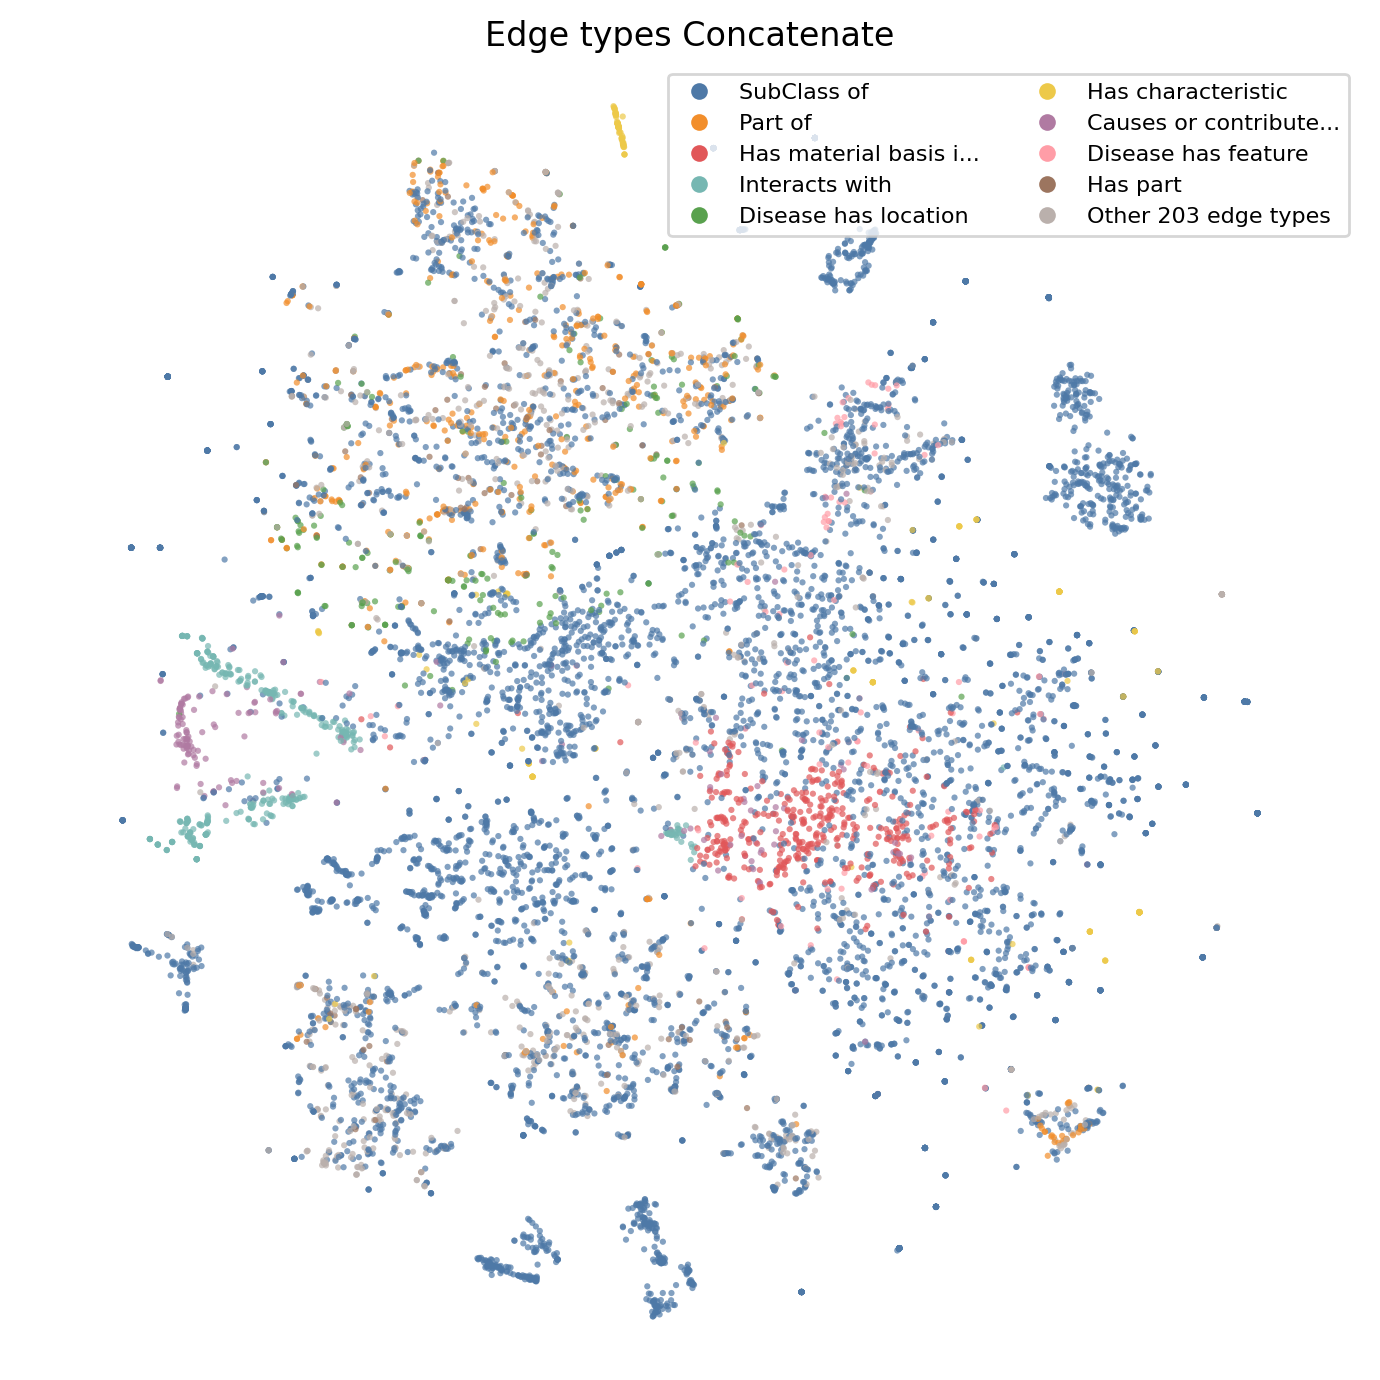

In [68]:
graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name="graph",
)

engine = Node2VecCBOWEnsmallen(walk_length=5)
embedding = engine.fit_transform(graph)
vis = GraphVisualizer(graph)

vis.fit_edges(embedding)
vis.plot_edge_types(k=9)

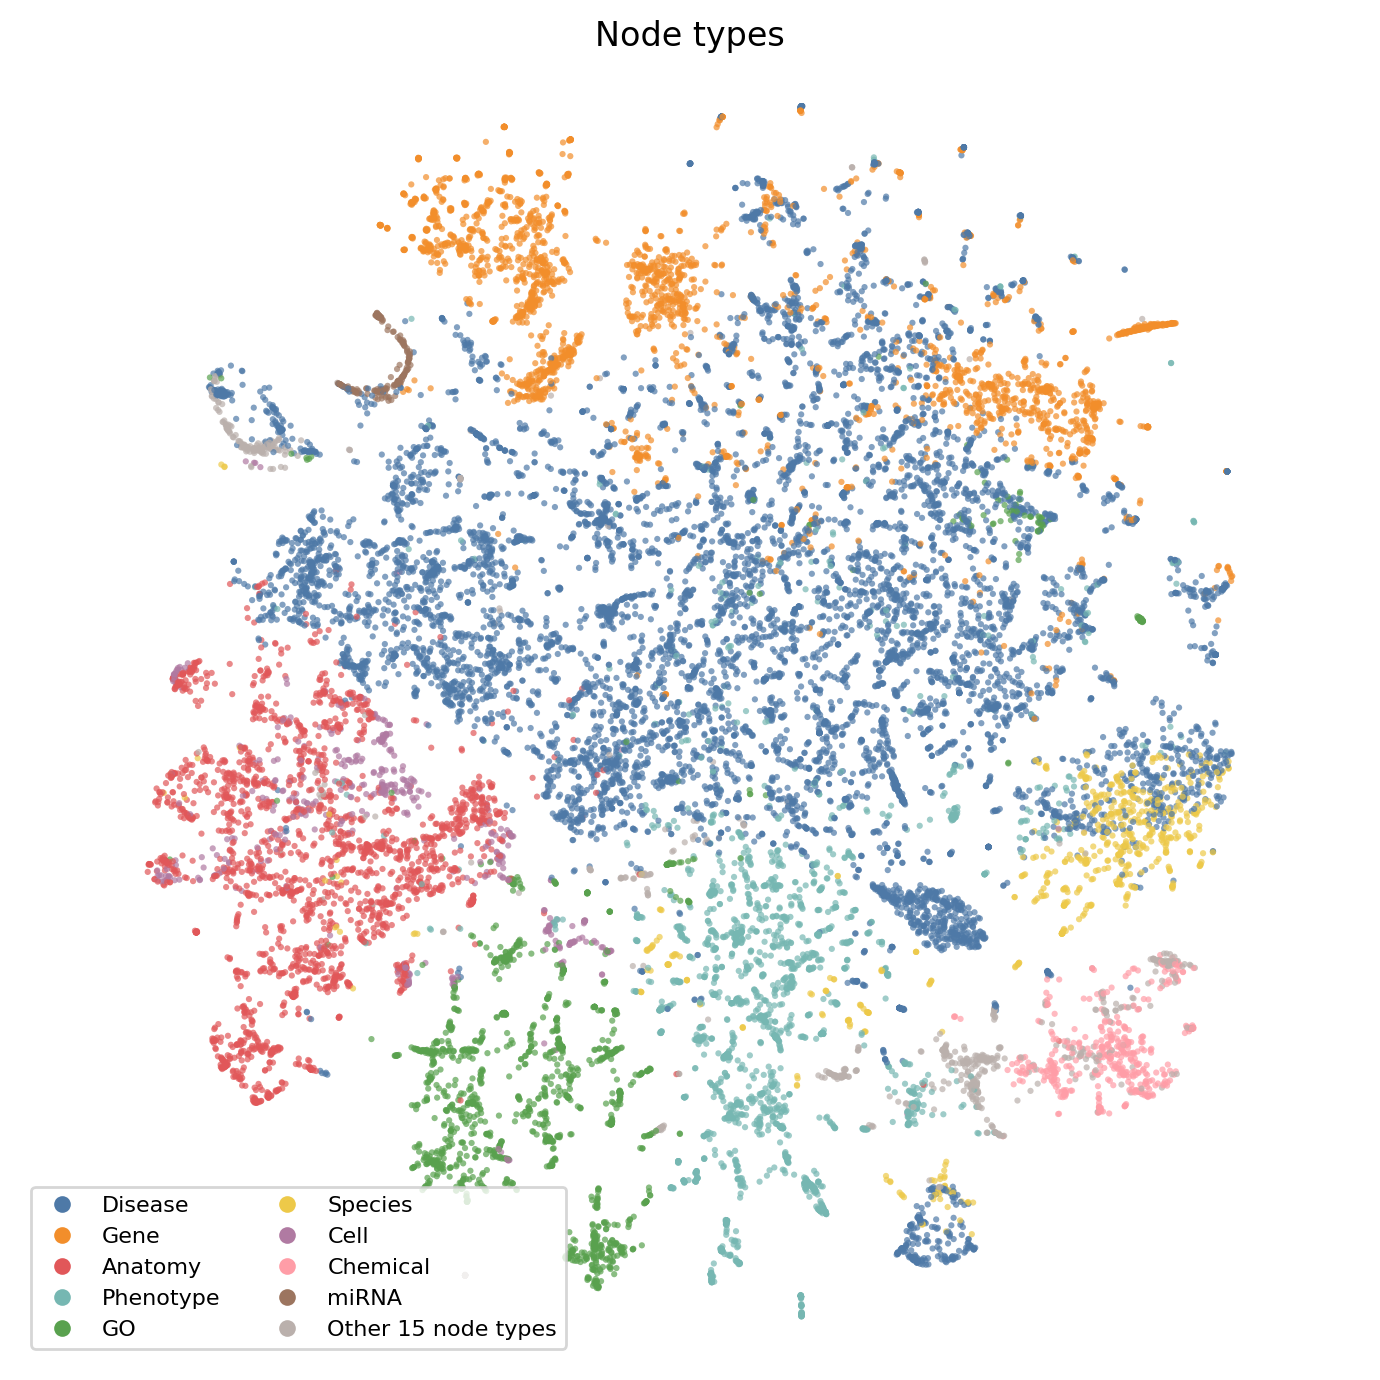

In [69]:
vis.fit_nodes(embedding)
vis.plot_node_types(k=9)

Now we want to infer new links within our KG by means of a Random Forest algorithm implementation. Our KG will be embedded using a Node2Vec algorithm implementation.

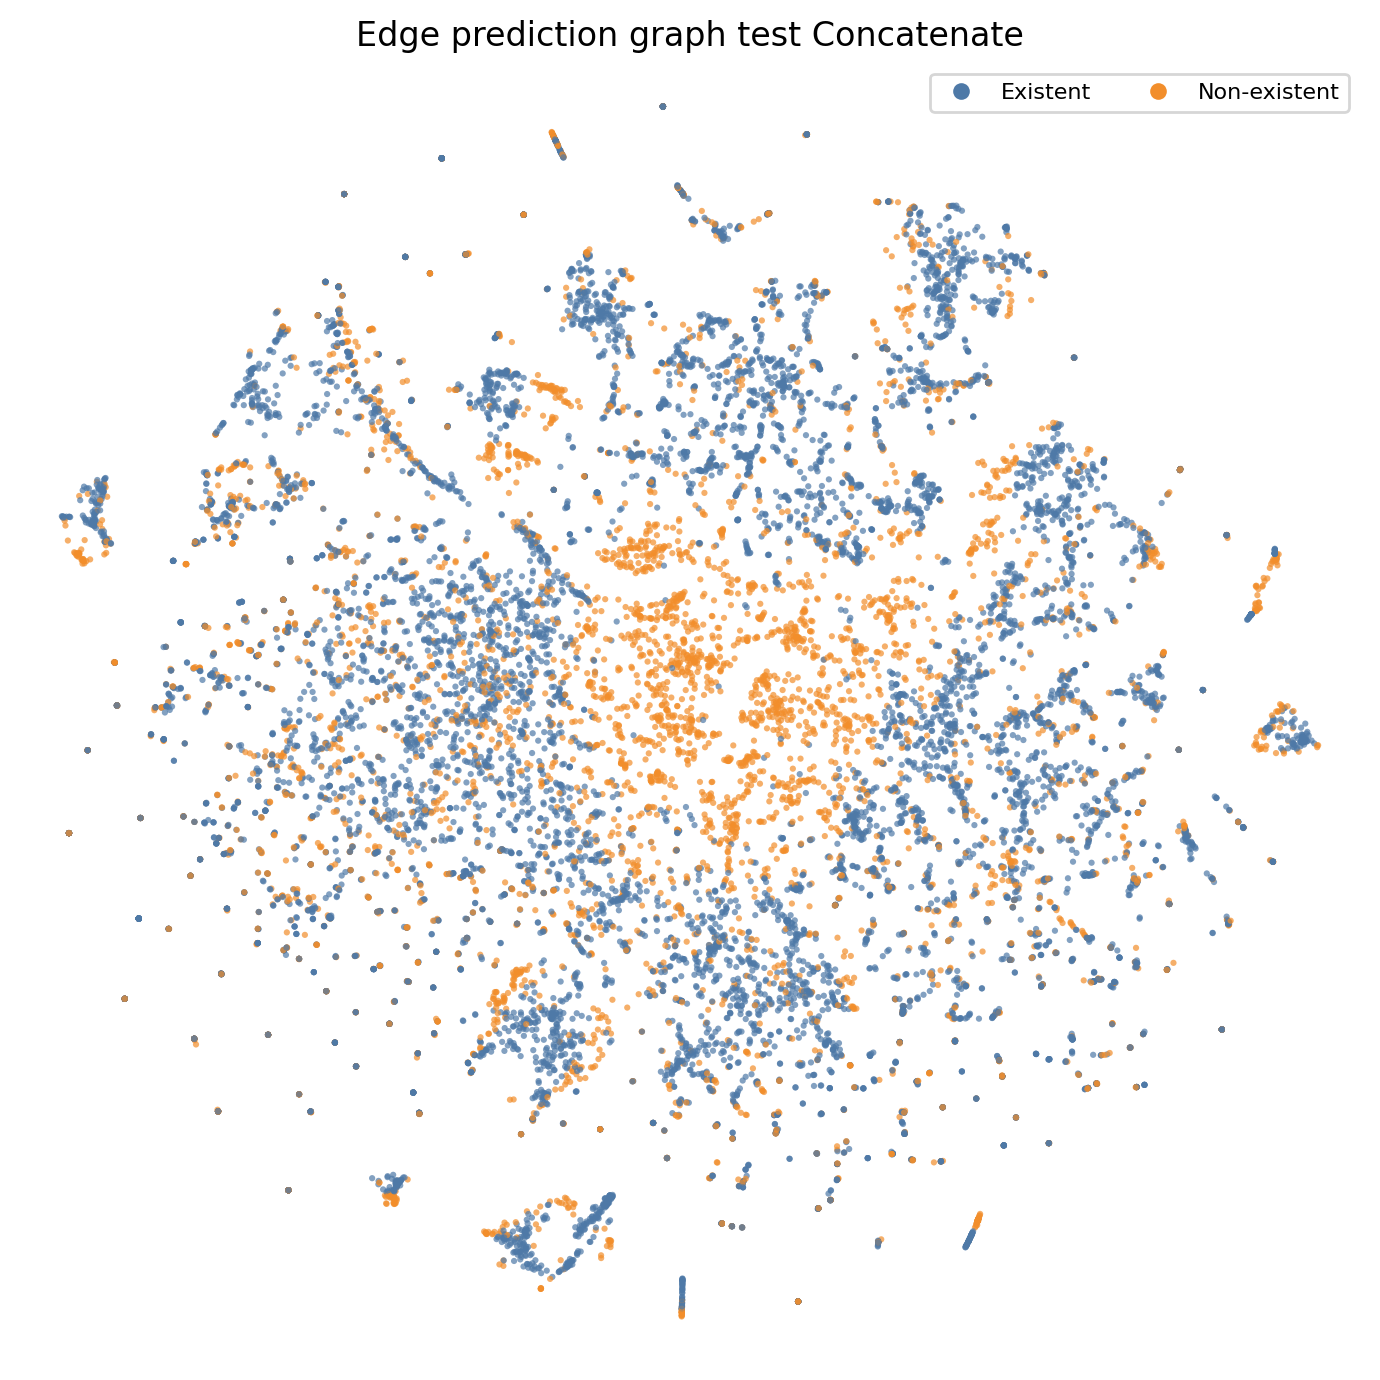

In [70]:
train, test = graph.connected_holdout(train_size=0.7)
train.enable()

vis = GraphVisualizer(
    graph=test,
    support=graph
)

vis.fit_negative_and_positive_edges(embedding)
vis.plot_positive_and_negative_edges()

In [71]:
%%time
embedding = Node2VecSkipGramEnsmallen(embedding_size=10).fit_transform(train)

CPU times: user 2h 36min 22s, sys: 615 ms, total: 2h 36min 22s
Wall time: 6min 32s


In [72]:
model = RandomForestEdgePrediction()

model.fit(
    graph=train, 
    node_features=embedding
)

In [73]:
%%time
# A perfect model should correctly predict the existance of all of these edges.
model_predictions = model.predict_proba(
    graph=test,
    node_features=embedding,
    return_predictions_dataframe=True
)
model_predictions.sample(5)

Running edge predictions:   0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 26.1 s, sys: 1.98 s, total: 28.1 s
Wall time: 9.72 s


,prediction,sources,destinations,edge_types
33735,0.419521,<http://purl.obolibrary.org/obo/MONDO_0009475>,<http://www.ncbi.nlm.nih.gov/gene/3712>,Has material basis in germline mutation in
63251,0.777417,<http://purl.obolibrary.org/obo/HP_0002992>,<http://purl.obolibrary.org/obo/HP_0040069>,SubClass of
64068,0.588116,<http://purl.obolibrary.org/obo/MONDO_0011523>,<http://purl.obolibrary.org/obo/MONDO_0015229>,SubClass of
55932,0.268418,<http://purl.obolibrary.org/obo/HP_0002086>,<http://purl.obolibrary.org/obo/BFO_0000001>,Type
11575,0.623473,<http://purl.obolibrary.org/obo/MONDO_0000764>,<http://purl.obolibrary.org/obo/MONDO_0011855>,SubClass of


In [74]:
%%time
# A perfect model should correctly predict the non-existance of all of these edges.
model_neg_predictions=model.predict_proba(
    graph=graph.sample_negative_graph(number_of_negative_samples=test.get_number_of_edges()),
    support=train,
    node_features=embedding,
    return_predictions_dataframe=True
)

model_neg_predictions.sample(5)

Running edge predictions:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 966 ms, total: 16.3 s
Wall time: 5.17 s


,prediction,sources,destinations,edge_types
8161,0.135209,<http://purl.obolibrary.org/obo/MONDO_0021228>,<http://purl.obolibrary.org/obo/MONDO_0005720>,SubClass of
12692,0.309655,<http://purl.obolibrary.org/obo/UBERON_0003695>,<http://purl.obolibrary.org/obo/MONDO_0700130>,SubClass of
6313,0.394763,<http://purl.obolibrary.org/obo/MONDO_0003847>,<http://purl.obolibrary.org/obo/MONDO_0019013>,SubClass of
14273,0.256076,<http://purl.obolibrary.org/obo/MONDO_0018612>,<http://www.ncbi.nlm.nih.gov/gene/64965>,Has material basis in germline mutation in
18302,0.371316,<http://purl.obolibrary.org/obo/CL_0002077>,<http://purl.obolibrary.org/obo/GO_0006865>,Has plasma membrane part


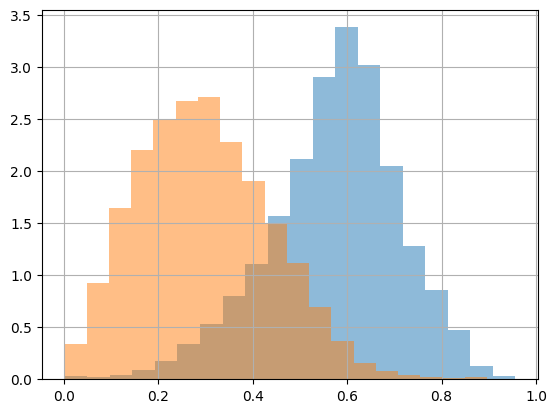

In [77]:
fig, ax = plt.subplots()
ax = model_predictions.prediction.hist(bins=20, alpha=0.5, density=True)
ax = model_neg_predictions.prediction.hist(bins=20, alpha=0.5, density=True)
plt.show()

In [78]:
#edges_to_predict_file = "/home/mauricio/RNA-KG/diseasemiRNA2bePredicted2.txt"
edges_to_predict_file = "/home/mauricio/RNA-KG/genemiRNA2bePredicted2.txt"

edges_to_predict = pd.read_csv(edges_to_predict_file,names=["subject","predicate","object"], sep='\t')
edges_to_predict.sample(3)

,subject,predicate,object
160198,<http://www.ncbi.nlm.nih.gov/gene/221092>,<http://purl.obolibrary.org/obo/RO_0002434>,<https://www.mirbase.org/hairpin/MI0000434>
84697,<http://www.ncbi.nlm.nih.gov/gene/8826>,<http://purl.obolibrary.org/obo/RO_0002434>,<https://www.mirbase.org/hairpin/MI0003177>
71212,<http://www.ncbi.nlm.nih.gov/gene/6648>,<http://purl.obolibrary.org/obo/RO_0002434>,<https://www.mirbase.org/hairpin/MI0000742>


In [79]:
# Remove edges with unknown nodes

sources_in_graph = edges_to_predict.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = edges_to_predict.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = edges_to_predict[edge_extremes_in_graph]
nodes_to_predict = pd.DataFrame(set(edges_to_predict['subject']).union(set(list(edges_to_predict_filtered['object']))), columns=["name"])
nodes_to_predict.sample(5)

[[False, 422], [True, 200876]]


,name
2164,<http://www.ncbi.nlm.nih.gov/gene/8546>
60,<http://www.ncbi.nlm.nih.gov/gene/9043>
2178,<http://www.ncbi.nlm.nih.gov/gene/10944>
1496,<http://www.ncbi.nlm.nih.gov/gene/8463>
1473,<http://www.ncbi.nlm.nih.gov/gene/7011>


In [80]:
nodes_to_predict.name.apply(lambda x: x in nodes_df.name.values).value_counts()

# Create graph for predictions
rna_kg_to_predict_graph = Graph.from_pd(
    edges_df=edges_to_predict_filtered,
    nodes_df=nodes_df,
    node_name_column="name",
    #node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="predicate",
    node_types_separator="|",
    directed=False,
    name="RNA-KG",
)
model_to_predict_predictions = model.predict_proba(
    graph=rna_kg_to_predict_graph,
    node_features=embedding,
    support=graph,
    return_predictions_dataframe=True
)

model_to_predict_predictions.sample(5)

Running edge predictions:   0%|          | 0/64 [00:00<?, ?it/s]

,prediction,sources,destinations,edge_types
124587,0.717450,<https://www.mirbase.org/hairpin/MI0003177>,<http://www.ncbi.nlm.nih.gov/gene/57826>,<http://purl.obolibrary.org/obo/RO_0002434>
185622,0.707727,<http://www.ncbi.nlm.nih.gov/gene/146434>,<https://www.mirbase.org/hairpin/MI0000084>,<http://purl.obolibrary.org/obo/RO_0002434>
93348,0.531536,<https://www.mirbase.org/hairpin/MI0000782>,<http://www.ncbi.nlm.nih.gov/gene/631>,<http://purl.obolibrary.org/obo/RO_0002434>
243517,0.503781,<http://www.ncbi.nlm.nih.gov/gene/2956>,<https://www.mirbase.org/hairpin/MI0008331>,<http://purl.obolibrary.org/obo/RO_0002434>
195576,0.708626,<http://www.ncbi.nlm.nih.gov/gene/26057>,<https://www.mirbase.org/hairpin/MI0000082>,<http://purl.obolibrary.org/obo/RO_0002434>


In [81]:
# identify edges already in the train grap
model_to_predict_predictions['is_in_RNA_KG'] = model_to_predict_predictions[['sources','destinations']].apply(tuple, axis=1)\
                  .isin(edges_df[['subject','object']].apply(tuple, axis=1))

model_to_predict_predictions.head(3)

,prediction,sources,destinations,edge_types,is_in_RNA_KG
0,0.699845,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0000439>,<http://purl.obolibrary.org/obo/RO_0002434>,False
1,0.682254,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0002469>,<http://purl.obolibrary.org/obo/RO_0002434>,False
2,0.717648,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0000489>,<http://purl.obolibrary.org/obo/RO_0002434>,False


In [82]:
model_to_predict_predictions[['is_in_RNA_KG','prediction']].groupby('is_in_RNA_KG').agg(['count','mean','std'])

prediction                    
                  count      mean       std
is_in_RNA_KG                               
False            251462  0.628738  0.093491
True               7678  0.690692  0.076647

In [83]:
#model_to_predict_predictions.to_pickle("./diseasemiRNA2bePredicted_predictions.pkl") 
model_to_predict_predictions.to_pickle("./genemiRNA2bePredicted_predictions.pkl") 

In [84]:
#predictions_diseases = pd.read_pickle("./diseasemiRNA2bePredicted_predictions.pkl")
predictions_genes = pd.read_pickle("./genemiRNA2bePredicted_predictions.pkl")

In [85]:
predictions_genes.head(3)

,prediction,sources,destinations,edge_types,is_in_RNA_KG
0,0.699845,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0000439>,<http://purl.obolibrary.org/obo/RO_0002434>,False
1,0.682254,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0002469>,<http://purl.obolibrary.org/obo/RO_0002434>,False
2,0.717648,<http://www.ncbi.nlm.nih.gov/gene/9805>,<https://www.mirbase.org/hairpin/MI0000489>,<http://purl.obolibrary.org/obo/RO_0002434>,False


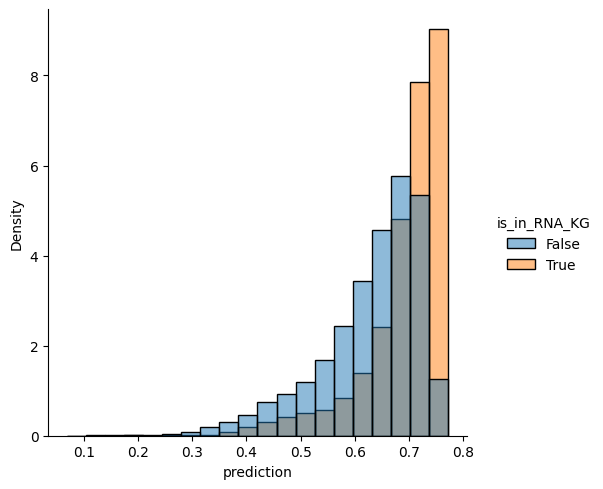

In [86]:
#sns.displot(predictions_diseases, x="prediction", hue="is_in_RNA_KG", stat="density", common_norm=False)
sns.displot(predictions_genes, x="prediction", hue="is_in_RNA_KG", stat="density", bins=20, common_norm=False)


***
# (POTENTIAL) ASSIGNMENTS

- Let us go back to the `miRNA_gene` dataframe. It has 'positive_negative', 'direct_indirect', and 'up_down' columns, that are edge properties. A refinment process for this KG would be promote these three properties to specific edge types. Check [RO](https://www.ebi.ac.uk/ols4/ontologies/ro) to retrieve relations more accurate than the generic "interacts with", split the dataframe according to these new three relations, and generate the refined KG using PheKnowLator. This analysis increases the semantic (and biological) information stored within your KG.

- Moreover, the `miRNA_gene` dataframe has a "transcript(3p/5p)" column. We can improve the KG by splitting stem-loop hairpin miRNA and mature sequences. The look-up table for mapping mature miRNA sequences to miRBase identifiers is already provided. Remember to store the -5p/-3p information about mature miRNA molecules as node properties. Bonus: what should I do if I find a "5p|3p" cell?
    - hsa-mir-15a --> https://www.mirbase.org/hairpin/MI0000069 (we already know it...)
    - hsa-miR-15a-5p --> https://www.mirbase.org/mature/MIMAT0000068
    - hsa-miR-15a-3p--> https://www.mirbase.org/mature/MIMAT0004488

- The previous improvement distinguishes mature and stem-loop sequences, but mature sequences are derived from stem-loops! We can store this information within the KG as a new bidirectional edge (look for "develops"-like relationships stored in RO on [OLS4](https://www.ebi.ac.uk/ols4/)). This is a good example of inference done by studying the underlying semantics of the KG domain, without considering any new dataset.  
    - hsa-mir-15a --> develops --> hsa-miR-15a-5p (hint: employ an RO property with an appropriate inverse)
    - hsa-mir-15a --> develops --> hsa-miR-15a-3p

- To improve look-up tables, you can move from a 1-to-1 mapping to an adaptive threshold mapping, e.g., map both "Parkinson disease" and "Parkinsons disease" strings to MONDO:0005180. Thresholds have be empirically validated, meaning a CLO mapping requires a lower threshold than a Mondo one (a proper threshold for mapping strings to Mondo could be 95%, a lower one could be employed for mapping strings to CLO). These assignments show KG construction and maintenance as a circular process that constantly improves the final KG to identify edge and node-subtypes and enhance grounding/mapping. 

- Analyze you newly generated KG(s) with GRAPE.

In [89]:
gene_miRNA[['subject','object','positive_negative','direct_indirect','up_down','transcript(3p/5p)']].head()

,subject,object,positive_negative,direct_indirect,up_down,transcript(3p/5p)
0,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000081>,POSITIVE,DIRECT,DOWN,5p
1,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000088>,POSITIVE,DIRECT,DOWN,3p
2,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000272>,POSITIVE,DIRECT,DOWN,5p
3,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000438>,POSITIVE,DIRECT,DOWN,5p
4,<http://www.ncbi.nlm.nih.gov/gene/10000>,<https://www.mirbase.org/hairpin/MI0000489>,POSITIVE,DIRECT,DOWN,5p


In [90]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

print(similar("Parkinson disease", "Parkinson disease"))
print(similar("Parkinson disease", "Parkinsons disease"))
print(similar("Parkinson disease", "Parkinsonss disease"))

1.0
0.9714285714285714
0.9444444444444444
